# IBM Applied Data Science Specialization Capstone - Hong Kong Sportswear Neighborhood Analysis

This is the capstone project for the IBM Applied Data Science Specialization.

## Preston Chou
email: preston.chou@yahoo.com

Downloading dependencies

In [410]:
!conda install -c conda-forge geopy --yes
!conda install -c conda-forge folium=0.5.0 --yes
!conda install -c conda-forge shapely

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.



In [940]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import re

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline

# import k-means from clustering stage, import make blobs and sillhouette analysis libraries
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score

import folium # map rendering library

from shapely.geometry import shape, Point

print('Libraries imported.')

Libraries imported.


## 1. Introduction

This data analytics project aims to explore which areas in Hong Kong are promising locations to open sportswear stores. The primary metric used to assess an area’s potential will be its number of fitness or clothing-related venues. Another metric will be each area's most common venue types. A greater number of such venues in an area implies greater interest in fitness lifestyles and/or clothing, and the presence of a “fitness/fashion ecosystem.”

The project is intended for the following audiences:
- Existing sportswear companies looking to optimize their store location strategy
- New start-ups looking to enter the market
- Hong Kong sportswear market analysts

## 2. Data Preparation

### Hong Kong Government Constituency Area data 

We will use a GeoJson file to acquire Hong Kong's Constituency Areas and put them into a dataframe. This file is ideal because it also contains the area boundary coordinates, which will be used to create choropleth maps.

In [1115]:
# Sourced from Hong Kong Geodata Store: https://geodata.gov.hk/gs/view-dataset?uuid=ddd39cbe-5f10-4dbd-96e7-7a4883e37388&l=en&sidx=0
with open('HKGS_Dataset_2019-District-Council-Ordinary-Election-Constituency-Boundaries_2019-02-21-0800-00_fullset.geojson') as HK_json:
    HK_geo_data = json.load(HK_json)

In [1116]:
# Creating lists for consituency areas and the broader districts they are part of.
constituency_list = []
district_list = []
for feature in HK_geo_features:
    constituency_list.append(feature['properties']['ENAME'])
    district_list.append(feature['properties']['DISTRICT_E'])

In [1117]:
constituency_list

['Sai Wan Ho',
 'Nam Fung',
 'Kornhill Garden',
 'Mount Parker',
 'Fortress Hill',
 'A Kung Ngam',
 'Kam Ping',
 'Fort Street',
 'Tanner',
 'Lei King Wan',
 'Tai Koo Shing East',
 'Tai Koo Shing West',
 'City Garden',
 'Provident',
 'Siu Sai Wan',
 'Tsui Tak',
 'Yue Wan',
 'Fei Tsui',
 'King Yee',
 'Hing Man',
 'Lok Hong',
 'Yan Lam',
 'Upper Yiu Tung',
 'Lower Yiu Tung',
 'Tsui Wan',
 'Shaukeiwan',
 'Aldrich Bay',
 'Heng Fa Chuen',
 'Hing Tung',
 'Kornhill',
 'Kwun Tong On Tai',
 'Sau Mau Ping Central',
 'King Tin',
 'Lam Tin',
 'Healthy Village',
 'Quarry Bay',
 'Braemar Hill',
 'Chun Cheung',
 'Yau Lai',
 'Hip Hong',
 'Upper Ngau Tau Kok Estate',
 'Hiu Lai',
 'Lok Wah South',
 'Lok Wah North',
 'Sau Mau Ping North',
 'Lower Ngau Tau Kok Estate',
 'To Tai',
 'Pak Nga',
 'Kowloon Bay',
 'Jordan Valley',
 'Shun Tin',
 'On Lee',
 'Kai Yip',
 'Choi Tak',
 'Po Tat',
 'Ping Shek',
 'Sheung Shun',
 'Lai Ching',
 'Lamma & Po Toi',
 'Mun Yat',
 'Yat Tung Estate North',
 'Peng Chau & Hei Ling 

In [1118]:
district_list

['Eastern District',
 'Eastern District',
 'Eastern District',
 'Eastern District',
 'Eastern District',
 'Eastern District',
 'Eastern District',
 'Eastern District',
 'Eastern District',
 'Eastern District',
 'Eastern District',
 'Eastern District',
 'Eastern District',
 'Eastern District',
 'Eastern District',
 'Eastern District',
 'Eastern District',
 'Eastern District',
 'Eastern District',
 'Eastern District',
 'Eastern District',
 'Eastern District',
 'Eastern District',
 'Eastern District',
 'Eastern District',
 'Eastern District',
 'Eastern District',
 'Eastern District',
 'Eastern District',
 'Eastern District',
 'Kwun Tong District',
 'Kwun Tong District',
 'Kwun Tong District',
 'Kwun Tong District',
 'Eastern District',
 'Eastern District',
 'Eastern District',
 'Kwun Tong District',
 'Kwun Tong District',
 'Kwun Tong District',
 'Kwun Tong District',
 'Kwun Tong District',
 'Kwun Tong District',
 'Kwun Tong District',
 'Kwun Tong District',
 'Kwun Tong District',
 'Kwun T

In [949]:
# Incorporate both lists to a dataframe
d = {'Hong Kong Constituency Areas': constituency_list, 'Hong Kong Constituency District': district_list}
hk_areas = pd.DataFrame(data=d)
hk_areas

Hong Kong Constituency Areas Hong Kong Constituency District
0                                Sai Wan Ho                Eastern District
1                                  Nam Fung                Eastern District
2                           Kornhill Garden                Eastern District
3                              Mount Parker                Eastern District
4                             Fortress Hill                Eastern District
5                               A Kung Ngam                Eastern District
6                                  Kam Ping                Eastern District
7                               Fort Street                Eastern District
8                                    Tanner                Eastern District
9                              Lei King Wan                Eastern District
10                       Tai Koo Shing East                Eastern District
11                       Tai Koo Shing West                Eastern District
12                              City Garden                Eastern District
13                                Provident                Eastern District
14                              Siu Sai Wan                Eastern District
15                                 Tsui Tak                Eastern District
16                                  Yue Wan                Eastern District
17                                 Fei Tsui                Eastern District
18                                 King Yee                Eastern District
19                                 Hing Man                Eastern District
20                                 Lok Hong                Eastern District
21                                  Yan Lam                Eastern District
22                           Upper Yiu Tung                Eastern District
23                           Lower Yiu Tung                Eastern District
24                                 Tsui Wan                Eastern District
25                               Shaukeiwan                Eastern District
26                              Aldrich Bay                Eastern District
27                            Heng Fa Chuen                Eastern District
28                                Hing Tung                Eastern District
29                                 Kornhill                Eastern District
30                         Kwun Tong On Tai              Kwun Tong District
31                     Sau Mau Ping Central              Kwun Tong District
32                                 King Tin              Kwun Tong District
33                                  Lam Tin              Kwun Tong District
34                          Healthy Village                Eastern District
35                               Quarry Bay                Eastern District
36                             Braemar Hill                Eastern District
37                              Chun Cheung              Kwun Tong District
38                                  Yau Lai              Kwun Tong District
39                                 Hip Hong              Kwun Tong District
40                Upper Ngau Tau Kok Estate              Kwun Tong District
41                                  Hiu Lai              Kwun Tong District
42                            Lok Wah South              Kwun Tong District
43                            Lok Wah North              Kwun Tong District
44                       Sau Mau Ping North              Kwun Tong District
45                Lower Ngau Tau Kok Estate              Kwun Tong District
46                                   To Tai              Kwun Tong District
47                                  Pak Nga              Kwun Tong District
48                              Kowloon Bay              Kwun Tong District
49                            Jordan Valley              Kwun Tong District
50                                 Shun Tin              Kwun Tong District
51                                   On Lee              Kwun T

### Nominatim Geocoder API Coordinate data

The next step is to acquire the latitude and longitude coordinates for the areas. The Geocoder API returns the most accurate coordinates when the input address includes the constituency area, followed by the district, and the city ('Hong Kong'). However, this input format yields far more 'None' values, which we need to deal with later on.

In [950]:
# Using Nominatim to loop through the addresses, appending values to our latitude and longitude lists.
geolocator = Nominatim(user_agent="sar_explorer")
latitude_list = []
longitude_list = []
for row in hk_areas.index:
    address = str(hk_areas.iloc[row,0] + ', ' + hk_areas.iloc[row,1] + ', Hong Kong')
    location = geolocator.geocode(address, timeout=5)
    if location is None:
        location = 'None'
        latitude_list.append(location)
        longitude_list.append(location)
    else:
        latitude = location.latitude
        longitude = location.longitude
        latitude_list.append(latitude)
        longitude_list.append(longitude)

In [951]:
# Adding our lists to new columns
hk_areas['Latitude'] = latitude_list
hk_areas['Longitude'] = longitude_list
hk_areas

Hong Kong Constituency Areas Hong Kong Constituency District  \
0                                Sai Wan Ho                Eastern District   
1                                  Nam Fung                Eastern District   
2                           Kornhill Garden                Eastern District   
3                              Mount Parker                Eastern District   
4                             Fortress Hill                Eastern District   
5                               A Kung Ngam                Eastern District   
6                                  Kam Ping                Eastern District   
7                               Fort Street                Eastern District   
8                                    Tanner                Eastern District   
9                              Lei King Wan                Eastern District   
10                       Tai Koo Shing East                Eastern District   
11                       Tai Koo Shing West                Eastern District   
12                              City Garden                Eastern District   
13                                Provident                Eastern District   
14                              Siu Sai Wan                Eastern District   
15                                 Tsui Tak                Eastern District   
16                                  Yue Wan                Eastern District   
17                                 Fei Tsui                Eastern District   
18                                 King Yee                Eastern District   
19                                 Hing Man                Eastern District   
20                                 Lok Hong                Eastern District   
21                                  Yan Lam                Eastern District   
22                           Upper Yiu Tung                Eastern District   
23                           Lower Yiu Tung                Eastern District   
24                                 Tsui Wan                Eastern District   
25                               Shaukeiwan                Eastern District   
26                              Aldrich Bay                Eastern District   
27                            Heng Fa Chuen                Eastern District   
28                                Hing Tung                Eastern District   
29                                 Kornhill                Eastern District   
30                         Kwun Tong On Tai              Kwun Tong District   
31                     Sau Mau Ping Central              Kwun Tong District   
32                                 King Tin              Kwun Tong District   
33                                  Lam Tin              Kwun Tong District   
34                          Healthy Village                Eastern District   
35                               Quarry Bay                Eastern District   
36                             Braemar Hill                Eastern District   
37                              Chun Cheung              Kwun Tong District   
38                                  Yau Lai              Kwun Tong District   
39                                 Hip Hong              Kwun Tong District   
40                Upper Ngau Tau Kok Estate              Kwun Tong District   
41                                  Hiu Lai              Kwun Tong District   
42                            Lok Wah South              Kwun Tong District   
43                            Lok Wah North              Kwun Tong District   
44                       Sau Mau Ping North              Kwun Tong District   
45                Lower Ngau Tau Kok Estate              Kwun Tong District   
46                                   To Tai              Kwun Tong District   
47                                  Pak Nga              Kwun Tong District   
48                              Kowloon Bay              Kwun Tong District   
49                            Jordan Valley              Kwun Ton

In [952]:
print(hk_areas[hk_areas['Latitude'] == 'None'].shape)
hk_areas[hk_areas['Latitude']=='None']

(115, 4)


Hong Kong Constituency Areas Hong Kong Constituency District  \
3                              Mount Parker                Eastern District   
6                                  Kam Ping                Eastern District   
10                       Tai Koo Shing East                Eastern District   
11                       Tai Koo Shing West                Eastern District   
13                                Provident                Eastern District   
15                                 Tsui Tak                Eastern District   
18                                 King Yee                Eastern District   
21                                  Yan Lam                Eastern District   
22                           Upper Yiu Tung                Eastern District   
23                           Lower Yiu Tung                Eastern District   
24                                 Tsui Wan                Eastern District   
28                                Hing Tung                Eastern District   
30                         Kwun Tong On Tai              Kwun Tong District   
32                                 King Tin              Kwun Tong District   
37                              Chun Cheung              Kwun Tong District   
38                                  Yau Lai              Kwun Tong District   
39                                 Hip Hong              Kwun Tong District   
41                                  Hiu Lai              Kwun Tong District   
47                                  Pak Nga              Kwun Tong District   
51                                   On Lee              Kwun Tong District   
53                                 Choi Tak              Kwun Tong District   
56                              Sheung Shun              Kwun Tong District   
57                                Lai Ching              Kwun Tong District   
58                           Lamma & Po Toi                Islands District   
61                Peng Chau & Hei Ling Chau                Islands District   
67                                Kwong Tak              Kwun Tong District   
72                                  Ting On              Kwun Tong District   
77                                 Hong Lok              Kwun Tong District   
82                                Tsui Hing               Tuen Mun District   
83                                King Hing               Tuen Mun District   
84                                Hing Tsak               Tuen Mun District   
89                                 San King               Tuen Mun District   
94                                 Lok Tsui               Tuen Mun District   
110        East Tsim Sha Tsui & King's Park          Yau Tsim Mong District   
113                                  Fu Pak          Yau Tsim Mong District   
134                                Wai Ying             Kwai Tsing District   
138                                   On Ho             Kwai Tsing District   
139                               Ching Fat             Kwai Tsing District   
141                                  Po Nga                 Tai Po District   
142                                  On Tat              Kwun Tong District   
148                        Lower Tai Wo Hau             Kwai Tsing District   
150                        Tai Pak Tin West             Kwai Tsing District   
154                        Tai Pak Tin East             Kwai Tsing District   
155                                Wan Tsui                Eastern District   
156                                 Kai Hiu                Eastern District   
162                                Yan Ying               Sai Kung District   
168                        Sai Kung Islands               Sai Kung District   
170                                 Wai Yan               Sai Kung District   
175                                 Hoi Nam                Sha Tin District   
177                                Yau Chui              Kwun Ton

As we can see, there are many locations that are not identified by the Geocoder API. The locations can be split into three main categories. The 1st category of these locations includes the names that contain very specific sub-area terms (e.g. North, South, East, West, Upper, Lower). For these instances, we can eliminate the sub-area terms and consolidate the names into one name (if its other sub-area location is located, then we simply delete the unidentifiable location).

The 2nd category conjoin two or more names (via commas or ampersands). We can form separate names for this category. 

The 3rd and most numerous category includes names that are simply too obscure for the Geocoder API. We can try to input their address to the Geocoder API as only the Constituency Area name and 'Hong Kong'. But given the unreliability of the API, we will check to see if the coordinate is contained within the area boundaries. We can simply eliminate the rows that are outside the boundries since most of them are small and adjacent to more identifiable areas.

In [953]:
# Category 1
# Create a new column with reformatted Constituency Area names for Geocoder API
hk_areas.insert(loc=1, column='Hong Kong Constituency Areas for Geocoder', value=hk_areas['Hong Kong Constituency Areas'])

In [954]:
hk_areas.at[10,'Hong Kong Constituency Areas for Geocoder'] = 'Taikoo Shing' # Geocoder API needs spacing to be 'Taikoo'
hk_areas.at[11,'Hong Kong Constituency Areas for Geocoder'] = 'Taikoo Shing'
hk_areas.at[22,'Hong Kong Constituency Areas for Geocoder'] = 'Yiu Tung'
hk_areas.at[23,'Hong Kong Constituency Areas for Geocoder'] = 'Yiu Tung'
hk_areas.at[150,'Hong Kong Constituency Areas for Geocoder'] = 'Tai Pak Tin'
hk_areas.at[154,'Hong Kong Constituency Areas for Geocoder'] = 'Tai Pak Tin'
hk_areas.at[188,'Hong Kong Constituency Areas for Geocoder'] = 'Shing Mun'
hk_areas.at[272,'Hong Kong Constituency Areas for Geocoder'] = 'Hok Yuen'
hk_areas.at[316,'Hong Kong Constituency Areas for Geocoder'] = 'Tin Ping'
hk_areas.at[317,'Hong Kong Constituency Areas for Geocoder'] = 'Tin Ping'
hk_areas.at[336,'Hong Kong Constituency Areas for Geocoder'] = 'Kingswood'
hk_areas[hk_areas['Latitude'] == 'None']

Hong Kong Constituency Areas  \
3                              Mount Parker   
6                                  Kam Ping   
10                       Tai Koo Shing East   
11                       Tai Koo Shing West   
13                                Provident   
15                                 Tsui Tak   
18                                 King Yee   
21                                  Yan Lam   
22                           Upper Yiu Tung   
23                           Lower Yiu Tung   
24                                 Tsui Wan   
28                                Hing Tung   
30                         Kwun Tong On Tai   
32                                 King Tin   
37                              Chun Cheung   
38                                  Yau Lai   
39                                 Hip Hong   
41                                  Hiu Lai   
47                                  Pak Nga   
51                                   On Lee   
53                                 Choi Tak   
56                              Sheung Shun   
57                                Lai Ching   
58                           Lamma & Po Toi   
61                Peng Chau & Hei Ling Chau   
67                                Kwong Tak   
72                                  Ting On   
77                                 Hong Lok   
82                                Tsui Hing   
83                                King Hing   
84                                Hing Tsak   
89                                 San King   
94                                 Lok Tsui   
110        East Tsim Sha Tsui & King's Park   
113                                  Fu Pak   
134                                Wai Ying   
138                                   On Ho   
139                               Ching Fat   
141                                  Po Nga   
142                                  On Tat   
148                        Lower Tai Wo Hau   
150                        Tai Pak Tin West   
154                        Tai Pak Tin East   
155                                Wan Tsui   
156                                 Kai Hiu   
162                                Yan Ying   
168                        Sai Kung Islands   
170                                 Wai Yan   
175                                 Hoi Nam   
177                                Yau Chui   
179                                  Hin Ka   
185                                 Chui Ka   
188                         Lower Shing Mun   
209                                Kam Ying   
212                                  Kam To   
230                               Bays Area   
231                        Stanley & Shek O   
244  Nam Shan, Tai Hang Tung & Tai Hang Sai   
246                              Ha Pak Tin   
248                                 Fortune   
249                                  Po Lai   
251                            Lei Cheng Uk   
254              Lung Ping & Sheung Pak Tin   
255                                 Pik Wui   
256                               Fu Cheong   
259                               Fung Tsui   
266                                Fung Nin   
271                                 Oi Chun   
272                   Hok Yuen Laguna Verde   
275                                Hoi Sham   
276                              Sheung Lok   
279                           Ma Hang Chung   
297                             Fu Ming Sun   
299                   Old Market & Serenity   
301                                Tai Yuen   
306                               Yan Shing   
307                                  Wah Do   
310                                Ching Ho   
315                            Fanling Town   
316                           Tin Ping East   
317                           Tin Ping West   
330                                 Yiu Yau   
331                                 Tsz Yau   
336                         Kingswood South   
337                 

In [955]:
# Category 2
# Split the 'Hong Kong Constituency Areas' column by '&' or ',', indexing to 'Hong Kong Constituency District' column values.
arrays = [np.array(hk_areas['Hong Kong Constituency Areas']), np.array(hk_areas['Hong Kong Constituency District'])]
hk_areas2 = pd.DataFrame(hk_areas.iloc[:,1].str.split(r'&|,').tolist(), index=arrays).stack()
hk_areas2 = pd.DataFrame(hk_areas2).reset_index()
hk_areas2.drop(columns=['level_2'], inplace=True)

# Strip all extra spaces at the beginning and end of each element
hk_areas2 = hk_areas2.applymap(lambda x: x.strip() if isinstance(x, str) else x)

# Rename columns
hk_areas2.rename(columns={'level_0':'Hong Kong Constituency Areas','level_1':'Hong Kong Constituency District', 0:'Hong Kong Constituency Areas for Geocoder'}, inplace=True)
hk_areas2

Hong Kong Constituency Areas Hong Kong Constituency District  \
0                                Sai Wan Ho                Eastern District   
1                                  Nam Fung                Eastern District   
2                           Kornhill Garden                Eastern District   
3                              Mount Parker                Eastern District   
4                             Fortress Hill                Eastern District   
5                               A Kung Ngam                Eastern District   
6                                  Kam Ping                Eastern District   
7                               Fort Street                Eastern District   
8                                    Tanner                Eastern District   
9                              Lei King Wan                Eastern District   
10                       Tai Koo Shing East                Eastern District   
11                       Tai Koo Shing West                Eastern District   
12                              City Garden                Eastern District   
13                                Provident                Eastern District   
14                              Siu Sai Wan                Eastern District   
15                                 Tsui Tak                Eastern District   
16                                  Yue Wan                Eastern District   
17                                 Fei Tsui                Eastern District   
18                                 King Yee                Eastern District   
19                                 Hing Man                Eastern District   
20                                 Lok Hong                Eastern District   
21                                  Yan Lam                Eastern District   
22                           Upper Yiu Tung                Eastern District   
23                           Lower Yiu Tung                Eastern District   
24                                 Tsui Wan                Eastern District   
25                               Shaukeiwan                Eastern District   
26                              Aldrich Bay                Eastern District   
27                            Heng Fa Chuen                Eastern District   
28                                Hing Tung                Eastern District   
29                                 Kornhill                Eastern District   
30                         Kwun Tong On Tai              Kwun Tong District   
31                     Sau Mau Ping Central              Kwun Tong District   
32                                 King Tin              Kwun Tong District   
33                                  Lam Tin              Kwun Tong District   
34                          Healthy Village                Eastern District   
35                               Quarry Bay                Eastern District   
36                             Braemar Hill                Eastern District   
37                              Chun Cheung              Kwun Tong District   
38                                  Yau Lai              Kwun Tong District   
39                                 Hip Hong              Kwun Tong District   
40                Upper Ngau Tau Kok Estate              Kwun Tong District   
41                                  Hiu Lai              Kwun Tong District   
42                            Lok Wah South              Kwun Tong District   
43                            Lok Wah North              Kwun Tong District   
44                       Sau Mau Ping North              Kwun Tong District   
45                Lower Ngau Tau Kok Estate              Kwun Tong District   
46                                   To Tai              Kwun Tong District   
47                                  Pak Nga              Kwun Tong District   
48                              Kowloon Bay              Kwun Tong District   
49                            Jordan Valley              Kwun Ton

In [956]:
# Reorder columns
hk_areas2 = hk_areas2[['Hong Kong Constituency Areas','Hong Kong Constituency Areas for Geocoder','Hong Kong Constituency District']]
hk_areas2

Hong Kong Constituency Areas  \
0                                Sai Wan Ho   
1                                  Nam Fung   
2                           Kornhill Garden   
3                              Mount Parker   
4                             Fortress Hill   
5                               A Kung Ngam   
6                                  Kam Ping   
7                               Fort Street   
8                                    Tanner   
9                              Lei King Wan   
10                       Tai Koo Shing East   
11                       Tai Koo Shing West   
12                              City Garden   
13                                Provident   
14                              Siu Sai Wan   
15                                 Tsui Tak   
16                                  Yue Wan   
17                                 Fei Tsui   
18                                 King Yee   
19                                 Hing Man   
20                                 Lok Hong   
21                                  Yan Lam   
22                           Upper Yiu Tung   
23                           Lower Yiu Tung   
24                                 Tsui Wan   
25                               Shaukeiwan   
26                              Aldrich Bay   
27                            Heng Fa Chuen   
28                                Hing Tung   
29                                 Kornhill   
30                         Kwun Tong On Tai   
31                     Sau Mau Ping Central   
32                                 King Tin   
33                                  Lam Tin   
34                          Healthy Village   
35                               Quarry Bay   
36                             Braemar Hill   
37                              Chun Cheung   
38                                  Yau Lai   
39                                 Hip Hong   
40                Upper Ngau Tau Kok Estate   
41                                  Hiu Lai   
42                            Lok Wah South   
43                            Lok Wah North   
44                       Sau Mau Ping North   
45                Lower Ngau Tau Kok Estate   
46                                   To Tai   
47                                  Pak Nga   
48                              Kowloon Bay   
49                            Jordan Valley   
50                                 Shun Tin   
51                                   On Lee   
52                                  Kai Yip   
53                                 Choi Tak   
54                                   Po Tat   
55                                Ping Shek   
56                              Sheung Shun   
57                                Lai Ching   
58                           Lamma & Po Toi   
59                           Lamma & Po Toi   
60                                  Mun Yat   
61                    Yat Tung Estate North   
62                Peng Chau & Hei Ling Chau   
63                Peng Chau & Hei Ling Chau   
64                       Tung Chung Central   
65                            Discovery Bay   
66                                   Lantau   
67                         Tung Chung North   
68                                 Hing Tin   
69                                Kwong Tak   
70                                 Yuet Wah   
71                       Sau Mau Ping South   
72                                Tsui Ping   
73                                   Po Lok   
74                                  Ting On   
75                            Yau Tong West   
76                                 Ping Tin   
77                              Laguna City   
78                        Kwun Tong Central   
79                                 Hong Lok   
80                             Yau Oi North   
81                                 Lung Mun   
82                     Tuen Mun Town Centre   
83                                Shan King   
84                  

In [957]:
# Using Nominatim to loop through the addresses of newly written Constituency Areas, appending values to our latitude and longitude lists.
geolocator = Nominatim(user_agent="sar_explorer")
latitude_list2 = []
longitude_list2 = []
for row in hk_areas2.index:
    address = str(hk_areas2.iloc[row,1] + ', ' + hk_areas2.iloc[row,2] + ', Hong Kong')
    location = geolocator.geocode(address, timeout=5)
    if location is None:
        location = 'None'
        latitude_list2.append(location)
        longitude_list2.append(location)
    else:
        latitude = location.latitude
        longitude = location.longitude
        latitude_list2.append(latitude)
        longitude_list2.append(longitude)

In [965]:
# Adding the new coordinate lists to new columns
hk_areas2.loc[:,'Latitude'] = latitude_list2
hk_areas2.loc[:,'Longitude'] = longitude_list2

# Create separate dataframe consisting entirely of the rows that Geocoder API still did not find coordinates for
hk_areas2_none = hk_areas2[hk_areas2.loc[:,'Latitude']=='None']
hk_areas2_none.reset_index(drop=True, inplace=True)
print(hk_areas2_none.shape)
hk_areas2_none

(106, 5)


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1783: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


Hong Kong Constituency Areas  \
0                              Mount Parker   
1                                  Kam Ping   
2                                 Provident   
3                                  Tsui Tak   
4                                  King Yee   
5                                   Yan Lam   
6                            Upper Yiu Tung   
7                            Lower Yiu Tung   
8                                  Tsui Wan   
9                                 Hing Tung   
10                         Kwun Tong On Tai   
11                                 King Tin   
12                              Chun Cheung   
13                                  Yau Lai   
14                                 Hip Hong   
15                                  Hiu Lai   
16                                  Pak Nga   
17                                   On Lee   
18                                 Choi Tak   
19                              Sheung Shun   
20                                Lai Ching   
21                                Kwong Tak   
22                                  Ting On   
23                                 Hong Lok   
24                                Tsui Hing   
25                                King Hing   
26                                Hing Tsak   
27                                 San King   
28                                 Lok Tsui   
29                                   Fu Pak   
30                                 Wai Ying   
31                                    On Ho   
32                                Ching Fat   
33                                   Po Nga   
34                                   On Tat   
35                         Lower Tai Wo Hau   
36                         Tai Pak Tin West   
37                         Tai Pak Tin East   
38                                 Wan Tsui   
39                                  Kai Hiu   
40                                 Yan Ying   
41                         Sai Kung Islands   
42                                  Wai Yan   
43                                  Hoi Nam   
44                                 Yau Chui   
45                                   Hin Ka   
46                                  Chui Ka   
47                                 Kam Ying   
48                                   Kam To   
49                                Bays Area   
50   Nam Shan, Tai Hang Tung & Tai Hang Sai   
51   Nam Shan, Tai Hang Tung & Tai Hang Sai   
52                               Ha Pak Tin   
53                                  Fortune   
54                                   Po Lai   
55                             Lei Cheng Uk   
56               Lung Ping & Sheung Pak Tin   
57                                  Pik Wui   
58                                Fu Cheong   
59                                Fung Tsui   
60                                 Fung Nin   
61                                  Oi Chun   
62                                 Hoi Sham   
63                               Sheung Lok   
64                            Ma Hang Chung   
65                              Fu Ming Sun   
66                    Old Market & Serenity   
67                                 Tai Yuen   
68                                Yan Shing   
69                                   Wah Do   
70                                 Ching Ho   
71                             Fanling Town   
72                                  Yiu Yau   
73                                  Tsz Yau   
74                                 Shui Wah   
75                                Chung Wah   
76                          Kingswood North   
77                                 Yuet Yan   
78                               Ching King   
79                                 Yat Chak   
80                                 Wang Yat   
81                                 Pek Long   
82                                 Hoi Chun   
83                                   O Tong   
84                  

In [966]:
# Category 3
# Using new address input format that skips over the District, we use Nominatim again to loop through the addresses, appending values to new latitude and longitude lists.
geolocator = Nominatim(user_agent="sar_rover")
latitude_list3 = []
longitude_list3 = []
for row in hk_areas2_none.index:
    address = str(hk_areas2_none.iloc[row,1] + ', Hong Kong')
    location = geolocator.geocode(address, timeout=10)
    if location is None:
        location = 'None'
        latitude_list3.append(location)
        longitude_list3.append(location)
    else:
        latitude = location.latitude
        longitude = location.longitude
        latitude_list3.append(latitude)
        longitude_list3.append(longitude)

In [969]:
# Adding the new coordinate lists to additional new columns (since we don't know whether to use these values yet)
hk_areas2_none.loc[:,'Latitude_new'] = latitude_list3
hk_areas2_none.loc[:,'Longitude_new'] = longitude_list3
hk_areas2_none

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1783: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


Hong Kong Constituency Areas  \
0                              Mount Parker   
1                                  Kam Ping   
2                                 Provident   
3                                  Tsui Tak   
4                                  King Yee   
5                                   Yan Lam   
6                            Upper Yiu Tung   
7                            Lower Yiu Tung   
8                                  Tsui Wan   
9                                 Hing Tung   
10                         Kwun Tong On Tai   
11                                 King Tin   
12                              Chun Cheung   
13                                  Yau Lai   
14                                 Hip Hong   
15                                  Hiu Lai   
16                                  Pak Nga   
17                                   On Lee   
18                                 Choi Tak   
19                              Sheung Shun   
20                                Lai Ching   
21                                Kwong Tak   
22                                  Ting On   
23                                 Hong Lok   
24                                Tsui Hing   
25                                King Hing   
26                                Hing Tsak   
27                                 San King   
28                                 Lok Tsui   
29                                   Fu Pak   
30                                 Wai Ying   
31                                    On Ho   
32                                Ching Fat   
33                                   Po Nga   
34                                   On Tat   
35                         Lower Tai Wo Hau   
36                         Tai Pak Tin West   
37                         Tai Pak Tin East   
38                                 Wan Tsui   
39                                  Kai Hiu   
40                                 Yan Ying   
41                         Sai Kung Islands   
42                                  Wai Yan   
43                                  Hoi Nam   
44                                 Yau Chui   
45                                   Hin Ka   
46                                  Chui Ka   
47                                 Kam Ying   
48                                   Kam To   
49                                Bays Area   
50   Nam Shan, Tai Hang Tung & Tai Hang Sai   
51   Nam Shan, Tai Hang Tung & Tai Hang Sai   
52                               Ha Pak Tin   
53                                  Fortune   
54                                   Po Lai   
55                             Lei Cheng Uk   
56               Lung Ping & Sheung Pak Tin   
57                                  Pik Wui   
58                                Fu Cheong   
59                                Fung Tsui   
60                                 Fung Nin   
61                                  Oi Chun   
62                                 Hoi Sham   
63                               Sheung Lok   
64                            Ma Hang Chung   
65                              Fu Ming Sun   
66                    Old Market & Serenity   
67                                 Tai Yuen   
68                                Yan Shing   
69                                   Wah Do   
70                                 Ching Ho   
71                             Fanling Town   
72                                  Yiu Yau   
73                                  Tsz Yau   
74                                 Shui Wah   
75                                Chung Wah   
76                          Kingswood North   
77                                 Yuet Yan   
78                               Ching King   
79                                 Yat Chak   
80                                 Wang Yat   
81                                 Pek Long   
82                                 Hoi Chun   
83                                   O Tong   
84                  

In [977]:
# Create inside_outside list that specifies the new coordinates as either Inside or Outside borders from 
# GeoJson file, or 'None' if the API still has nothing

inside_outside = []
for row in hk_areas2_none.index:
    if hk_areas2_none.iloc[row,5] == 'None':
        inside_outside.append('None')
    else:
        # Using Point class
        point = Point(hk_areas2_none.iloc[row,6], hk_areas2_none.iloc[row,5])
        name = hk_areas2_none.iloc[row,0]
        for feature in HK_geo_data['features']:
            # Use boundaries to create shape object if name matches
            if feature['properties']['ENAME'] == name:
                polygon = shape(feature['geometry'])
                if polygon.contains(point):
                    inside_outside.append('Inside borders')
                else:
                    inside_outside.append('Outside borders')

In [978]:
# Create new column using the list values
hk_areas2_none.loc[:,'Inside/Outside GeoJson Borders'] = inside_outside
hk_areas2_none

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


Hong Kong Constituency Areas  \
0                              Mount Parker   
1                                  Kam Ping   
2                                 Provident   
3                                  Tsui Tak   
4                                  King Yee   
5                                   Yan Lam   
6                            Upper Yiu Tung   
7                            Lower Yiu Tung   
8                                  Tsui Wan   
9                                 Hing Tung   
10                         Kwun Tong On Tai   
11                                 King Tin   
12                              Chun Cheung   
13                                  Yau Lai   
14                                 Hip Hong   
15                                  Hiu Lai   
16                                  Pak Nga   
17                                   On Lee   
18                                 Choi Tak   
19                              Sheung Shun   
20                                Lai Ching   
21                                Kwong Tak   
22                                  Ting On   
23                                 Hong Lok   
24                                Tsui Hing   
25                                King Hing   
26                                Hing Tsak   
27                                 San King   
28                                 Lok Tsui   
29                                   Fu Pak   
30                                 Wai Ying   
31                                    On Ho   
32                                Ching Fat   
33                                   Po Nga   
34                                   On Tat   
35                         Lower Tai Wo Hau   
36                         Tai Pak Tin West   
37                         Tai Pak Tin East   
38                                 Wan Tsui   
39                                  Kai Hiu   
40                                 Yan Ying   
41                         Sai Kung Islands   
42                                  Wai Yan   
43                                  Hoi Nam   
44                                 Yau Chui   
45                                   Hin Ka   
46                                  Chui Ka   
47                                 Kam Ying   
48                                   Kam To   
49                                Bays Area   
50   Nam Shan, Tai Hang Tung & Tai Hang Sai   
51   Nam Shan, Tai Hang Tung & Tai Hang Sai   
52                               Ha Pak Tin   
53                                  Fortune   
54                                   Po Lai   
55                             Lei Cheng Uk   
56               Lung Ping & Sheung Pak Tin   
57                                  Pik Wui   
58                                Fu Cheong   
59                                Fung Tsui   
60                                 Fung Nin   
61                                  Oi Chun   
62                                 Hoi Sham   
63                               Sheung Lok   
64                            Ma Hang Chung   
65                              Fu Ming Sun   
66                    Old Market & Serenity   
67                                 Tai Yuen   
68                                Yan Shing   
69                                   Wah Do   
70                                 Ching Ho   
71                             Fanling Town   
72                                  Yiu Yau   
73                                  Tsz Yau   
74                                 Shui Wah   
75                                Chung Wah   
76                          Kingswood North   
77                                 Yuet Yan   
78                               Ching King   
79                                 Yat Chak   
80                                 Wang Yat   
81                                 Pek Long   
82                                 Hoi Chun   
83                                   O Tong   
84                  

In [979]:
# Create new dataframe that comprises of all the Constituency Areas
hk_areas3 = hk_areas2

In [981]:
# Loop through the new hk_areas3 dataframe, replace 'None' coordinate values with new values from hk_areas2_none
# if new values are 'Inside borders'
for row in hk_areas3.index:
    if hk_areas3.loc[row,'Latitude'] != 'None':
        continue
    if hk_areas3.loc[row,'Latitude'] == 'None':
        none_index = np.where(hk_areas2_none.loc[:,'Hong Kong Constituency Areas']==hk_areas3.loc[row,'Hong Kong Constituency Areas'])[0][0]
        if hk_areas2_none.loc[none_index,'Inside/Outside GeoJson Borders'] == 'Inside borders':
            hk_areas3.loc[row,'Latitude'] = hk_areas2_none.loc[none_index,'Latitude_new']
            hk_areas3.loc[row,'Longitude'] = hk_areas2_none.loc[none_index,'Longitude_new']
        else:
            continue

In [983]:
# New hk_areas3 dataframe
hk_areas3

Hong Kong Constituency Areas  \
0                                Sai Wan Ho   
1                                  Nam Fung   
2                           Kornhill Garden   
3                              Mount Parker   
4                             Fortress Hill   
5                               A Kung Ngam   
6                                  Kam Ping   
7                               Fort Street   
8                                    Tanner   
9                              Lei King Wan   
10                       Tai Koo Shing East   
11                       Tai Koo Shing West   
12                              City Garden   
13                                Provident   
14                              Siu Sai Wan   
15                                 Tsui Tak   
16                                  Yue Wan   
17                                 Fei Tsui   
18                                 King Yee   
19                                 Hing Man   
20                                 Lok Hong   
21                                  Yan Lam   
22                           Upper Yiu Tung   
23                           Lower Yiu Tung   
24                                 Tsui Wan   
25                               Shaukeiwan   
26                              Aldrich Bay   
27                            Heng Fa Chuen   
28                                Hing Tung   
29                                 Kornhill   
30                         Kwun Tong On Tai   
31                     Sau Mau Ping Central   
32                                 King Tin   
33                                  Lam Tin   
34                          Healthy Village   
35                               Quarry Bay   
36                             Braemar Hill   
37                              Chun Cheung   
38                                  Yau Lai   
39                                 Hip Hong   
40                Upper Ngau Tau Kok Estate   
41                                  Hiu Lai   
42                            Lok Wah South   
43                            Lok Wah North   
44                       Sau Mau Ping North   
45                Lower Ngau Tau Kok Estate   
46                                   To Tai   
47                                  Pak Nga   
48                              Kowloon Bay   
49                            Jordan Valley   
50                                 Shun Tin   
51                                   On Lee   
52                                  Kai Yip   
53                                 Choi Tak   
54                                   Po Tat   
55                                Ping Shek   
56                              Sheung Shun   
57                                Lai Ching   
58                           Lamma & Po Toi   
59                           Lamma & Po Toi   
60                                  Mun Yat   
61                    Yat Tung Estate North   
62                Peng Chau & Hei Ling Chau   
63                Peng Chau & Hei Ling Chau   
64                       Tung Chung Central   
65                            Discovery Bay   
66                                   Lantau   
67                         Tung Chung North   
68                                 Hing Tin   
69                                Kwong Tak   
70                                 Yuet Wah   
71                       Sau Mau Ping South   
72                                Tsui Ping   
73                                   Po Lok   
74                                  Ting On   
75                            Yau Tong West   
76                                 Ping Tin   
77                              Laguna City   
78                        Kwun Tong Central   
79                                 Hong Lok   
80                             Yau Oi North   
81                                 Lung Mun   
82                     Tuen Mun Town Centre   
83                                Shan King   
84                  

In [984]:
# We drop the remaining rows that still have 'None' as their coordinates
index = hk_areas3[hk_areas3['Latitude']=='None'].index
hk_areas3 = hk_areas3.drop(index, axis=0).reset_index(drop=True)
hk_areas3

Hong Kong Constituency Areas  \
0                                Sai Wan Ho   
1                                  Nam Fung   
2                           Kornhill Garden   
3                             Fortress Hill   
4                               A Kung Ngam   
5                               Fort Street   
6                                    Tanner   
7                              Lei King Wan   
8                        Tai Koo Shing East   
9                        Tai Koo Shing West   
10                              City Garden   
11                              Siu Sai Wan   
12                                  Yue Wan   
13                                 Fei Tsui   
14                                 Hing Man   
15                                 Lok Hong   
16                           Upper Yiu Tung   
17                               Shaukeiwan   
18                              Aldrich Bay   
19                            Heng Fa Chuen   
20                                 Kornhill   
21                     Sau Mau Ping Central   
22                                  Lam Tin   
23                          Healthy Village   
24                               Quarry Bay   
25                             Braemar Hill   
26                Upper Ngau Tau Kok Estate   
27                                  Hiu Lai   
28                            Lok Wah South   
29                            Lok Wah North   
30                       Sau Mau Ping North   
31                Lower Ngau Tau Kok Estate   
32                                   To Tai   
33                              Kowloon Bay   
34                            Jordan Valley   
35                                 Shun Tin   
36                                  Kai Yip   
37                                   Po Tat   
38                                Ping Shek   
39                           Lamma & Po Toi   
40                           Lamma & Po Toi   
41                                  Mun Yat   
42                    Yat Tung Estate North   
43                Peng Chau & Hei Ling Chau   
44                Peng Chau & Hei Ling Chau   
45                       Tung Chung Central   
46                            Discovery Bay   
47                                   Lantau   
48                         Tung Chung North   
49                                 Hing Tin   
50                                 Yuet Wah   
51                       Sau Mau Ping South   
52                                Tsui Ping   
53                                   Po Lok   
54                            Yau Tong West   
55                                 Ping Tin   
56                              Laguna City   
57                        Kwun Tong Central   
58                             Yau Oi North   
59                                 Lung Mun   
60                     Tuen Mun Town Centre   
61                                Shan King   
62                                 Tin King   
63                                Sam Shing   
64                               Leung King   
65                                 Kin Sang   
66                               Prime View   
67                                 Siu Hong   
68                                  San Hui   
69                                   Fu Tai   
70                           Tuen Mun Rural   
71                                   Po Tin   
72                              So Kwun Wat   
73                                  Hanford   
74                                  Yan Tin   
75                              Cheung Chau   
76                   Kwai Shing East Estate   
77                   Kwai Shing West Estate   
78                                Kwai Fong   
79                         Tung Chung South   
80                    Tsim Sha Tsui Central   
81                             Jordan North   
82                              Jordan West   
83                         Yau Ma Tei South   
84                  

###  Foursquare API Venue Data

For each Constituency Area, we want to acquire venue data through the FourSquare API. Let's create a function that iterates through the names and coordinates of each Area, acquires the nearby venues from the API, and creates a new dataframe containing information about the venues

*FourSquare credentials information is removed for security purposes*

In [986]:
def getNearbyVenues(names, latitudes, longitudes, radius):
    
    LIMIT = 300
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Hong Kong Constituency Areas', 
                  'Constituency Area Latitude', 
                  'Constituency Area Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [987]:
# Input the columns from hk_areas3 dataframe to the function, create new dataframe listing all the venues
hk_venues = getNearbyVenues(names=hk_areas3['Hong Kong Constituency Areas'], latitudes=hk_areas3['Latitude'], longitudes=hk_areas3['Longitude'], radius=500)
print(hk_venues.shape)
hk_venues.head(200)

(8650, 7)


Hong Kong Constituency Areas  Constituency Area Latitude  \
0                     Sai Wan Ho                   22.282446   
1                     Sai Wan Ho                   22.282446   
2                     Sai Wan Ho                   22.282446   
3                     Sai Wan Ho                   22.282446   
4                     Sai Wan Ho                   22.282446   
5                     Sai Wan Ho                   22.282446   
6                     Sai Wan Ho                   22.282446   
7                     Sai Wan Ho                   22.282446   
8                     Sai Wan Ho                   22.282446   
9                     Sai Wan Ho                   22.282446   
10                    Sai Wan Ho                   22.282446   
11                    Sai Wan Ho                   22.282446   
12                      Nam Fung                   22.442702   
13                      Nam Fung                   22.442702   
14                      Nam Fung                   22.442702   
15                      Nam Fung                   22.442702   
16                      Nam Fung                   22.442702   
17                      Nam Fung                   22.442702   
18                      Nam Fung                   22.442702   
19                      Nam Fung                   22.442702   
20                      Nam Fung                   22.442702   
21                      Nam Fung                   22.442702   
22                      Nam Fung                   22.442702   
23                      Nam Fung                   22.442702   
24                      Nam Fung                   22.442702   
25                      Nam Fung                   22.442702   
26                      Nam Fung                   22.442702   
27                      Nam Fung                   22.442702   
28                      Nam Fung                   22.442702   
29                      Nam Fung                   22.442702   
30                      Nam Fung                   22.442702   
31                      Nam Fung                   22.442702   
32                      Nam Fung                   22.442702   
33                      Nam Fung                   22.442702   
34                      Nam Fung                   22.442702   
35                      Nam Fung                   22.442702   
36                      Nam Fung                   22.442702   
37                      Nam Fung                   22.442702   
38                      Nam Fung                   22.442702   
39                      Nam Fung                   22.442702   
40                      Nam Fung                   22.442702   
41                      Nam Fung                   22.442702   
42                      Nam Fung                   22.442702   
43                      Nam Fung                   22.442702   
44                      Nam Fung                   22.442702   
45                      Nam Fung                   22.442702   
46                      Nam Fung                   22.442702   
47                      Nam Fung                   22.442702   
48                      Nam Fung                   22.442702   
49                      Nam Fung                   22.442702   
50                      Nam Fung                   22.442702   
51                      Nam Fung                   22.442702   
52                      Nam Fung                   22.442702   
53                      Nam Fung                   22.442702   
54                      Nam Fung                   22.442702   
55                      Nam Fung                   22.442702   
56                      Nam Fung                   22.442702   
57               Kornhill Garden                   22.285267   
58               Kornhill Garden                   22.285267   
59               Kornhill Garden                   22.285267   
60               Kornhill Garden                   22.285267   
61               Kornhill Garden    

Let's produce a new dataframe with dummy values for the venue categories. Scanning through the venue categories, we will only include categories with fitness or clothing-related key words that imply potential suitability to open a sportswear store.

In [988]:
# Producing dataframe with dummy values for venue categories
hk_venues_dummies = pd.get_dummies(hk_venues['Venue Category'])
hk_venues_dummies.head(10)

ATM  Accessories Store  Airport Service  American Restaurant  Amphitheater  \
0    0                  0                0                    0             0   
1    0                  0                0                    0             0   
2    0                  0                0                    0             0   
3    0                  0                0                    0             0   
4    0                  0                0                    0             0   
5    0                  0                0                    0             0   
6    0                  0                0                    0             0   
7    0                  0                0                    0             0   
8    0                  0                0                    0             0   
9    0                  0                0                    0             0   

   Arcade  Argentinian Restaurant  Art Gallery  Art Museum  \
0       0                       0            0           0   
1       0                       0            0           0   
2       0                       0            0           0   
3       0                       0            0           0   
4       0                       0            0           0   
5       0                       0            0           0   
6       0                       0            0           0   
7       0                       0            0           0   
8       0                       0            0           0   
9       0                       0            0           0   

   Arts & Crafts Store  Asian Restaurant  Astrologer  Athletics & Sports  \
0                    0                 0           0                   0   
1                    0                 0           0                   0   
2                    0                 0           0                   0   
3                    0                 0           0                   0   
4                    0                 0           0                   0   
5                    0                 0           0                   0   
6                    0                 0           0                   0   
7                    0                 0           0                   0   
8                    0                 0           0                   0   
9                    0                 0           0                   0   

   Australian Restaurant  Auto Garage  BBQ Joint  Bakery  Bank  Bar  Beach  \
0                      0            0          0       0     0    0      0   
1                      0            0          0       0     0    0      0   
2                      0            0          0       0     0    0      0   
3                      0            0          0       0     0    0      0   
4                      0            0          0       0     0    0      0   
5                      0            0          0       0     0    0      0   
6                      0            0          0       0     0    0      0   
7                      0            0          0       0     0    0      0   
8                      0            0          0       0     0    0      0   
9                      0            0          0       0     0    0      0   

   Bed & Breakfast  Beer Bar  Beer Garden  Beer Store  Beijing Restaurant  \
0                0         0            0           0                   0   
1                0         0            0           0                   0   
2                0         0            0           0                   0   
3                0         0            0           0                   0   
4                0         0            0           0                   0   
5                0         0            0           0                   0   
6                0         0            0           0                   0   
7                0         0            0           0                   0   
8                0         0           

In [989]:
# Filter through this dataframe to only include columns with relevant categories, producing array of boolean values
import re
keywords = 'sports|sport|sporting|fitness|gym|studio|field|pool|martial art|court|clothing|fashion|outdoor|shoes|shopping'
contains = hk_venues_dummies.columns.str.contains(keywords, flags=re.IGNORECASE, regex=True)
contains

array([False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True,  True, False, False, False,  True, False,
       False, False, False, False, False, False,  True, False,  True,
       False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True,  True,  True, False, False, False, False, False, False,
       False, False,

In [990]:
# Based on the boolean array, filter through the venue categories to include categories that are 'True'
i = 0
filtered_categories = []
for category in hk_venues_dummies.columns:
    if contains[i] == True:
        filtered_categories.append(category)
    i += 1
filtered_categories

['Athletics & Sports',
 'Boxing Gym',
 'Climbing Gym',
 'Clothing Store',
 'College Gym',
 'Cycle Studio',
 'Dance Studio',
 'Design Studio',
 'Food Court',
 'Gym',
 'Gym / Fitness Center',
 'Gym Pool',
 'Martial Arts School',
 'Massage Studio',
 'Outdoor Sculpture',
 'Outdoor Supply Store',
 'Paintball Field',
 'Pool',
 'Shopping Mall',
 'Shopping Plaza',
 'Soccer Field',
 'Sporting Goods Shop',
 'Sports Bar',
 'Sports Club',
 'Tennis Court',
 'Yoga Studio']

In [996]:
# Filter the dataframe, only include columns from the filtered_categories list
hk_venues_dummies_filtered = hk_venues_dummies[filtered_categories]
hk_venues_dummies_filtered.head()

Athletics & Sports  Boxing Gym  Climbing Gym  Clothing Store  College Gym  \
0                   0           0             0               0            0   
1                   0           0             0               0            0   
2                   0           0             0               0            0   
3                   0           0             0               0            0   
4                   0           0             0               0            0   

   Cycle Studio  Dance Studio  Design Studio  Food Court  Gym  \
0             0             0              0           0    0   
1             0             0              0           0    0   
2             0             0              0           0    0   
3             0             0              0           0    0   
4             0             0              0           0    0   

   Gym / Fitness Center  Gym Pool  Martial Arts School  Massage Studio  \
0                     0         0                    0               0   
1                     0         0                    0               0   
2                     0         0                    0               0   
3                     0         0                    0               0   
4                     0         0                    0               0   

   Outdoor Sculpture  Outdoor Supply Store  Paintball Field  Pool  \
0                  0                     0                0     0   
1                  0                     0                0     0   
2                  0                     0                0     0   
3                  0                     0                0     0   
4                  0                     0                0     0   

   Shopping Mall  Shopping Plaza  Soccer Field  Sporting Goods Shop  \
0              0               0             0                    0   
1              0               0             0                    0   
2              0               0             0                    0   
3              0               0             0                    0   
4              0               0             0                    0   

   Sports Bar  Sports Club  Tennis Court  Yoga Studio  
0           0            0             0            0  
1           0            0             0            0  
2           0            0             0            0  
3           0            0             0            0  
4           0            0             0            0

In [997]:
# Drop columns with irrelevant categories
hk_venues_dummies_filtered.drop(columns=['Design Studio','Food Court','Massage Studio','Outdoor Sculpture','Sports Bar'], inplace=True)
hk_venues_dummies_filtered.head()

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Athletics & Sports  Boxing Gym  Climbing Gym  Clothing Store  College Gym  \
0                   0           0             0               0            0   
1                   0           0             0               0            0   
2                   0           0             0               0            0   
3                   0           0             0               0            0   
4                   0           0             0               0            0   

   Cycle Studio  Dance Studio  Gym  Gym / Fitness Center  Gym Pool  \
0             0             0    0                     0         0   
1             0             0    0                     0         0   
2             0             0    0                     0         0   
3             0             0    0                     0         0   
4             0             0    0                     0         0   

   Martial Arts School  Outdoor Supply Store  Paintball Field  Pool  \
0                    0                     0                0     0   
1                    0                     0                0     0   
2                    0                     0                0     0   
3                    0                     0                0     0   
4                    0                     0                0     0   

   Shopping Mall  Shopping Plaza  Soccer Field  Sporting Goods Shop  \
0              0               0             0                    0   
1              0               0             0                    0   
2              0               0             0                    0   
3              0               0             0                    0   
4              0               0             0                    0   

   Sports Club  Tennis Court  Yoga Studio  
0            0             0            0  
1            0             0            0  
2            0             0            0  
3            0             0            0  
4            0             0            0

Let's now add a Constituency Area column, followed by grouping by Constituency Area by sum for each venue category.

In [998]:
# Insert Constituency Area column
hk_venues_dummies_filtered.insert(loc=0, column='Hong Kong Constituency Areas', value=hk_venues['Hong Kong Constituency Areas'])
hk_venues_dummies_filtered.head(50)

Hong Kong Constituency Areas  Athletics & Sports  Boxing Gym  Climbing Gym  \
0                    Sai Wan Ho                   0           0             0   
1                    Sai Wan Ho                   0           0             0   
2                    Sai Wan Ho                   0           0             0   
3                    Sai Wan Ho                   0           0             0   
4                    Sai Wan Ho                   0           0             0   
5                    Sai Wan Ho                   0           0             0   
6                    Sai Wan Ho                   0           0             0   
7                    Sai Wan Ho                   0           0             0   
8                    Sai Wan Ho                   0           0             0   
9                    Sai Wan Ho                   0           0             0   
10                   Sai Wan Ho                   0           0             0   
11                   Sai Wan Ho                   0           0             0   
12                     Nam Fung                   0           0             0   
13                     Nam Fung                   0           0             0   
14                     Nam Fung                   0           0             0   
15                     Nam Fung                   0           0             0   
16                     Nam Fung                   0           0             0   
17                     Nam Fung                   0           0             0   
18                     Nam Fung                   0           0             0   
19                     Nam Fung                   0           0             0   
20                     Nam Fung                   0           0             0   
21                     Nam Fung                   0           0             0   
22                     Nam Fung                   0           0             0   
23                     Nam Fung                   0           0             0   
24                     Nam Fung                   0           0             0   
25                     Nam Fung                   0           0             0   
26                     Nam Fung                   0           0             0   
27                     Nam Fung                   0           0             0   
28                     Nam Fung                   0           0             0   
29                     Nam Fung                   0           0             0   
30                     Nam Fung                   0           0             0   
31                     Nam Fung                   0           0             0   
32                     Nam Fung                   0           0             0   
33                     Nam Fung                   0           0             0   
34                     Nam Fung                   0           0             0   
35                     Nam Fung                   0           0             0   
36                     Nam Fung                   0           0             0   
37                     Nam Fung                   0           0             0   
38                     Nam Fung                   0           0             0   
39                     Nam Fung                   0           0             0   
40                     Nam Fung                   0           0             0   
41                     Nam Fung                   0           0             0   
42                     Nam Fung                   0           0             0   
43                     Nam Fung                   1           0             0   
44                     Nam Fung                   0           0             0   
45                     Nam Fung                   0           0             0   
46                     Nam Fung                   0           0             0   
47                     Nam Fung                   0           0             0   
48                     Nam Fung   

In [999]:
# Group by Constituency Areas
hk_venues_grouped = hk_venues_dummies_filtered.groupby('Hong Kong Constituency Areas').sum().reset_index()
hk_venues_grouped

Hong Kong Constituency Areas  Athletics & Sports  Boxing Gym  \
0                               A Kung Ngam                   0           0   
1                                  Aberdeen                   2           0   
2                               Aldrich Bay                   0           0   
3                                    Allway                   0           0   
4                        Ap Lei Chau Estate                   0           0   
5                         Ap Lei Chau North                   0           0   
6                                   Bik Woo                   0           0   
7                              Braemar Hill                   0           0   
8                                 Broadwood                   1           0   
9                                 Butterfly                   0           0   
10                               Canal Road                   0           0   
11                              Castle Road                   0           0   
12                             Causeway Bay                   0           0   
13                            Centre Street                   1           1   
14                                 Charming                   0           0   
15                                   Cherry                   0           0   
16                              Cheung Chau                   0           0   
17                             Cheung Ching                   0           0   
18                              Cheung Hang                   0           0   
19                              Cheung Hong                   0           0   
20                                Cheung On                   0           0   
21                           Cheung Sha Wan                   2           0   
22                              Cheung Shek                   0           0   
23                               Cheung Wah                   0           0   
24                                   Chi Fu                   0           0   
25                                  Cho Yiu                   1           0   
26                                Choi Hung                   1           0   
27                                 Choi Kin                   1           0   
28                            Choi Wan East                   0           0   
29                           Choi Wan South                   0           0   
30                            Choi Wan West                   0           0   
31                                Choi Yuen                   0           0   
32                                 Chui Tin                   0           0   
33                          Chuk Yuen North                   0           0   
34                          Chuk Yuen South                   0           0   
35                                Chun Fung                   0           0   
36                                  Chun Ma                   0           0   
37                                 Chung On                   1           0   
38                                Chung Pak                   1           0   
39                                Chung Tin                   0           0   
40                               Chung Ting                   0           0   
41                                Chung Wan                   0           0   
42                              City Garden                   0           0   
43                                 City One                   0           0   
44                                   Di Yee                   0           0   
45                            Discovery Bay                   0           0   
46                           Discovery Park                   0           0   
47                                  Do Shin                   0           0   
48         East Tsim Sha Tsui & King's Park                   1           0   
49                            Fairview Park                   0  

In [1000]:
# Add a 'Total' column that sums up total number of venue for each Constituency Area
hk_venues_grouped['Total'] = hk_venues_grouped.sum(axis=1)
hk_venues_grouped

Hong Kong Constituency Areas  Athletics & Sports  Boxing Gym  \
0                               A Kung Ngam                   0           0   
1                                  Aberdeen                   2           0   
2                               Aldrich Bay                   0           0   
3                                    Allway                   0           0   
4                        Ap Lei Chau Estate                   0           0   
5                         Ap Lei Chau North                   0           0   
6                                   Bik Woo                   0           0   
7                              Braemar Hill                   0           0   
8                                 Broadwood                   1           0   
9                                 Butterfly                   0           0   
10                               Canal Road                   0           0   
11                              Castle Road                   0           0   
12                             Causeway Bay                   0           0   
13                            Centre Street                   1           1   
14                                 Charming                   0           0   
15                                   Cherry                   0           0   
16                              Cheung Chau                   0           0   
17                             Cheung Ching                   0           0   
18                              Cheung Hang                   0           0   
19                              Cheung Hong                   0           0   
20                                Cheung On                   0           0   
21                           Cheung Sha Wan                   2           0   
22                              Cheung Shek                   0           0   
23                               Cheung Wah                   0           0   
24                                   Chi Fu                   0           0   
25                                  Cho Yiu                   1           0   
26                                Choi Hung                   1           0   
27                                 Choi Kin                   1           0   
28                            Choi Wan East                   0           0   
29                           Choi Wan South                   0           0   
30                            Choi Wan West                   0           0   
31                                Choi Yuen                   0           0   
32                                 Chui Tin                   0           0   
33                          Chuk Yuen North                   0           0   
34                          Chuk Yuen South                   0           0   
35                                Chun Fung                   0           0   
36                                  Chun Ma                   0           0   
37                                 Chung On                   1           0   
38                                Chung Pak                   1           0   
39                                Chung Tin                   0           0   
40                               Chung Ting                   0           0   
41                                Chung Wan                   0           0   
42                              City Garden                   0           0   
43                                 City One                   0           0   
44                                   Di Yee                   0           0   
45                            Discovery Bay                   0           0   
46                           Discovery Park                   0           0   
47                                  Do Shin                   0           0   
48         East Tsim Sha Tsui & King's Park                   1           0   
49                            Fairview Park                   0  

# 3. Data Analysis

Our data analysis has a couple objectives in mind. The 1st objective is to ascertain which areas in Hong Kong have more relevant venues. Areas with more venues are likely to be promising sportswear store locations.

The 2nd objective is to understand the venue-makeup of these areas. This provides another dimension by which to assess the suitability of an area.

The 1st objective is more straightforward (we already have 'Total' venue information). For the 2nd objective, we will employ K-means clustering to categorize the areas by the makeup of their venue-type.

In [1001]:
# Defining a function to sort the most common categories, and then use this function to create the dataframe.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [1069]:
# Choosing to assess areas based on their top 10 most common venue categories
num_top_venues = 10

# Create columns according to number of top venues
indicators = ['st', 'nd', 'rd']
columns = ['Hong Kong Constituency Areas']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# Create a new dataframe
hk_venues_sorted = pd.DataFrame(columns=columns)
hk_venues_sorted['Hong Kong Constituency Areas'] = hk_venues_grouped['Hong Kong Constituency Areas']

for ind in np.arange(hk_venues_grouped.shape[0]):
    hk_venues_sorted.iloc[ind, 1:] = return_most_common_venues(hk_venues_grouped.iloc[ind, :-1], num_top_venues)

hk_venues_sorted

Hong Kong Constituency Areas 1st Most Common Venue  \
0                               A Kung Ngam           Yoga Studio   
1                                  Aberdeen    Athletics & Sports   
2                               Aldrich Bay           Yoga Studio   
3                                    Allway           Yoga Studio   
4                        Ap Lei Chau Estate         Shopping Mall   
5                         Ap Lei Chau North         Shopping Mall   
6                                   Bik Woo         Shopping Mall   
7                              Braemar Hill           Yoga Studio   
8                                 Broadwood    Athletics & Sports   
9                                 Butterfly         Shopping Mall   
10                               Canal Road        Clothing Store   
11                              Castle Road           Yoga Studio   
12                             Causeway Bay        Clothing Store   
13                            Centre Street    Athletics & Sports   
14                                 Charming        Clothing Store   
15                                   Cherry        Clothing Store   
16                              Cheung Chau           Yoga Studio   
17                             Cheung Ching           Yoga Studio   
18                              Cheung Hang  Gym / Fitness Center   
19                              Cheung Hong  Gym / Fitness Center   
20                                Cheung On         Shopping Mall   
21                           Cheung Sha Wan    Athletics & Sports   
22                              Cheung Shek           Yoga Studio   
23                               Cheung Wah           Yoga Studio   
24                                   Chi Fu         Shopping Mall   
25                                  Cho Yiu    Athletics & Sports   
26                                Choi Hung    Athletics & Sports   
27                                 Choi Kin    Athletics & Sports   
28                            Choi Wan East         Shopping Mall   
29                           Choi Wan South         Shopping Mall   
30                            Choi Wan West         Shopping Mall   
31                                Choi Yuen           Yoga Studio   
32                                 Chui Tin         Shopping Mall   
33                          Chuk Yuen North         Shopping Mall   
34                          Chuk Yuen South         Shopping Mall   
35                                Chun Fung           Yoga Studio   
36                                  Chun Ma           Yoga Studio   
37                                 Chung On    Athletics & Sports   
38                                Chung Pak    Athletics & Sports   
39                                Chung Tin              Gym Pool   
40                               Chung Ting         Shopping Mall   
41                                Chung Wan         Shopping Mall   
42                              City Garden         Shopping Mall   
43                                 City One           Yoga Studio   
44                                   Di Yee         Shopping Mall   
45                            Discovery Bay           Yoga Studio   
46                           Discovery Park         Shopping Mall   
47                                  Do Shin           Yoga Studio   
48         East Tsim Sha Tsui & King's Park         Shopping Mall   
49                            Fairview Park         Shopping Mall   
50                            Fanling South           Yoga Studio   
51                             Fanling Town           Yoga Studio   
52                                 Fei Tsui         Shopping Mall   
53                                   Fo Tan           Yoga Studio   
54                              Fort Street           Yoga Studio   
55                            Fortress Hill                   Gym   
56                                  Fu Heng           Yoga Studio   
57           

### Elbow Method

Before we start the K-Means Clustering analysis, we should decide on the precise number of clusters to use.

We can determine this through a couple methods, the first being the Elbow Method. We run K-Means clustering for a range of K-values. For each K-value, we find the average of the squared distances for each point from the center of its selected cluster. In the plot, we choose the K-value after which the line appears to descend in a more linear pattern.

In [1034]:
# Create dataframe for K-means clustering. We first drop all rows for areas with 0 relevant venues.
hk_grouped_clustering = hk_venues_grouped.drop(hk_venues_grouped[hk_venues_grouped.Total == 0].index)

# We then drop columns for area names and total venue counts 
hk_grouped_clustering = hk_grouped_clustering.drop(['Hong Kong Constituency Areas','Total'], 1)

distortions = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(hk_grouped_clustering)
    distortions.append(kmeanModel.inertia_)

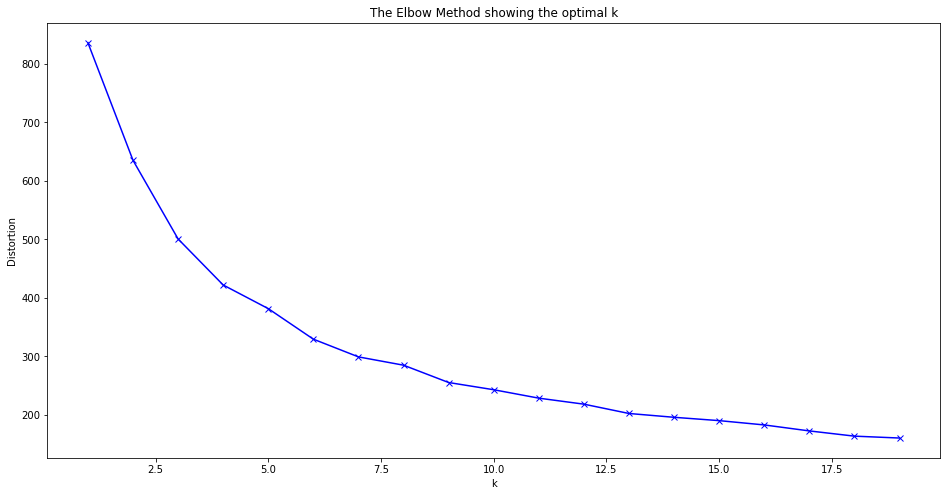

In [1028]:
# Plotting the results of the K-Means Clustering analysis
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

The curve does not have an extremely sharp elbow, but we can see that the line begins to resemble in a straight line in the 10-15 range. We should use another method to better decide on the precise K-value to use.

### Silhouette Analysis

The Silhouette Analysis method measures the degree of separation between the clusters . The method calculate a score for each sample point, reflecting its distance from other clusters. The scoring range runs from -1 to +1. -1 implies that the sample point is much closer to another cluster and therefore incorrectly assigned. +1 implies that the sample point is very close to its own assigned cluster. Each cluster has its own silhouette coefficient, and an average silhouette score is calculated for a given K-value.

We will also produce a silhouette plot that shows the silhouette coefficient, and the thickness of the plot reflects the size of the cluster size.

For n_clusters = 2 Average silhouette_score = 0.30989660701186794
For n_clusters = 3 Average silhouette_score = 0.3324970097497605
For n_clusters = 4 Average silhouette_score = 0.3856071570985365
For n_clusters = 5 Average silhouette_score = 0.26582083042547267
For n_clusters = 6 Average silhouette_score = 0.2684904915157421
For n_clusters = 7 Average silhouette_score = 0.2917072742360841
For n_clusters = 8 Average silhouette_score = 0.2941787921071116
For n_clusters = 9 Average silhouette_score = 0.31486471614870215
For n_clusters = 10 Average silhouette_score = 0.34565090362621814
For n_clusters = 11 Average silhouette_score = 0.32243710050245344
For n_clusters = 12 Average silhouette_score = 0.3218181470577988
For n_clusters = 13 Average silhouette_score = 0.3463772608405005
For n_clusters = 14 Average silhouette_score = 0.34345664554056665
For n_clusters = 15 Average silhouette_score = 0.3491730880071366


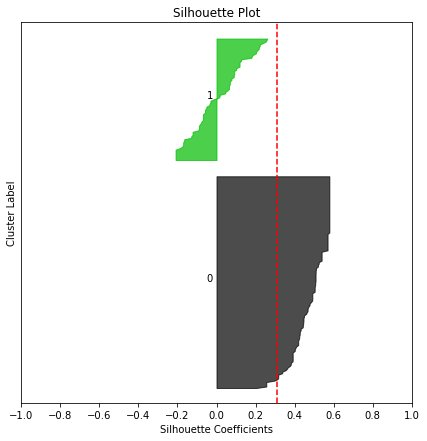

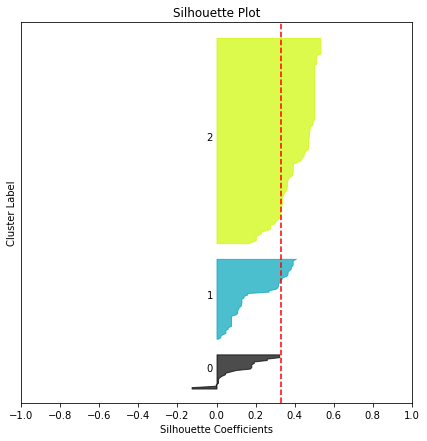

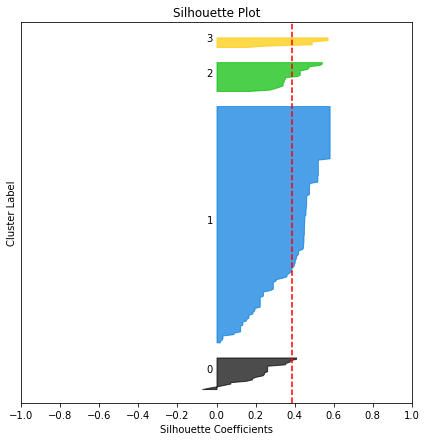

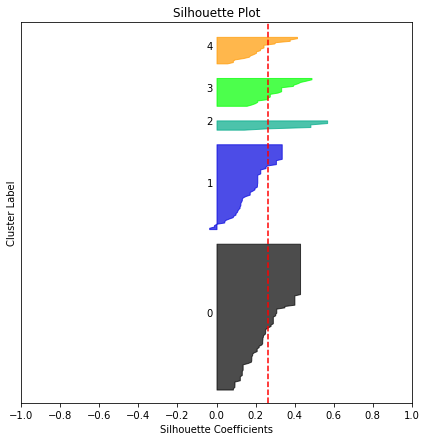

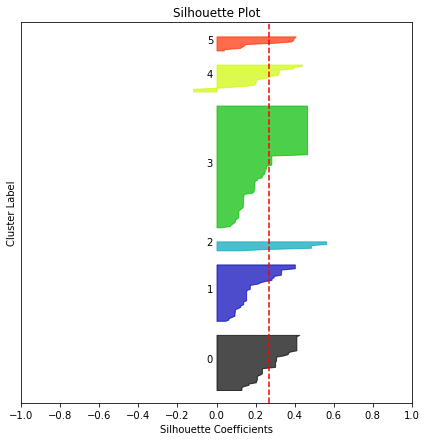

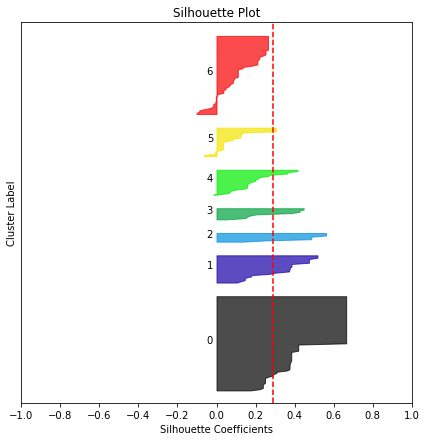

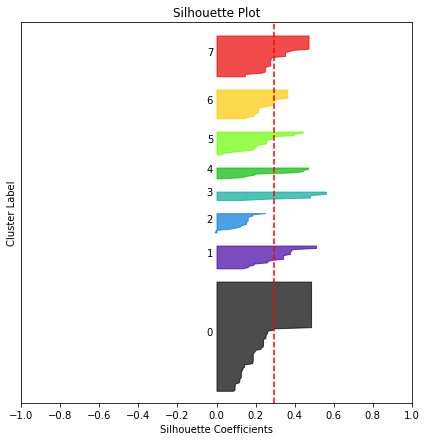

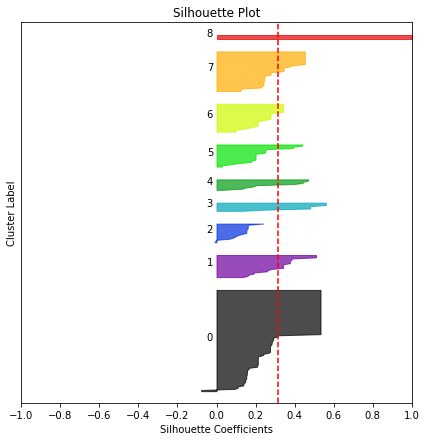

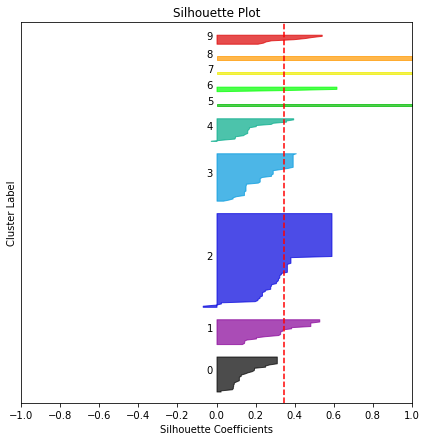

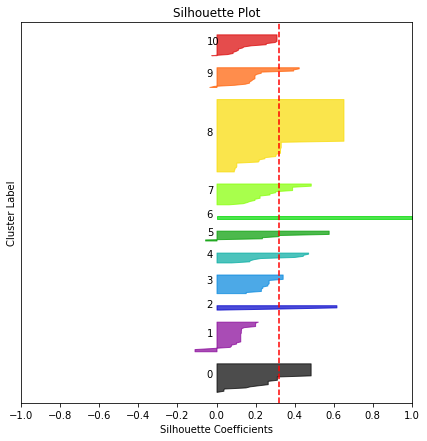

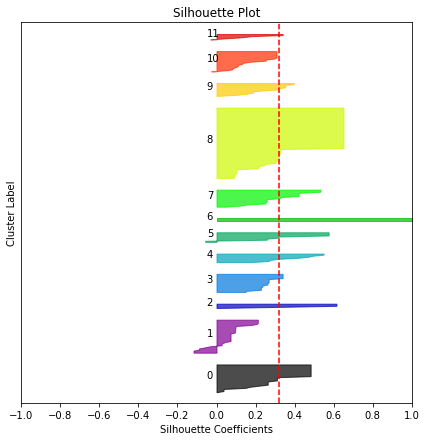

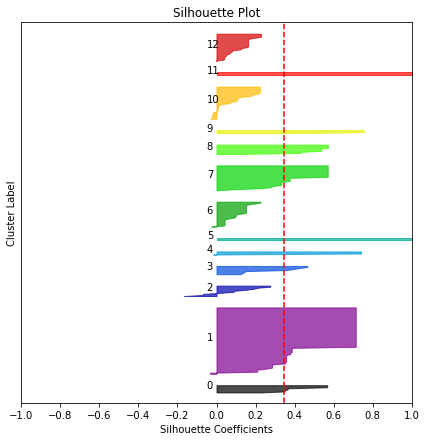

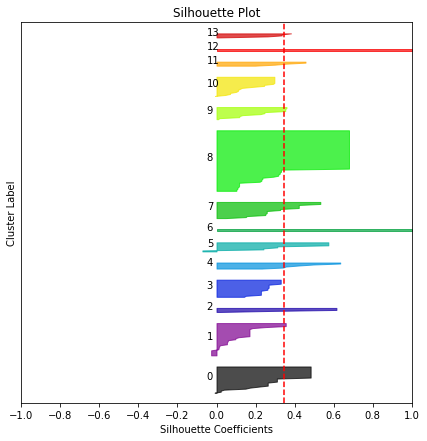

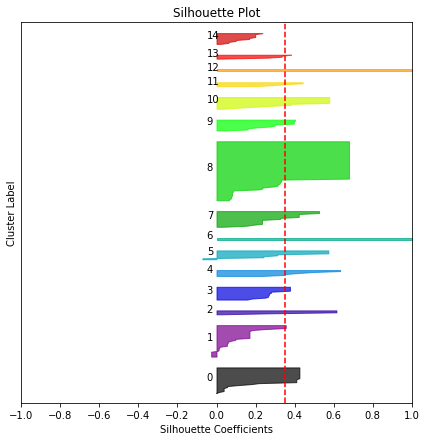

In [1030]:
# Range of K-values from 2 to 15
range_n_clusters = np.arange(16)[2:]

X = hk_grouped_clustering

for n_clusters in range_n_clusters:
    fig, ax1 = plt.subplots()
    fig.set_size_inches(7, 7)

    # Setting X-axis for full range of silhouette coefficient (-1, 1)
    ax1.set_xlim([-1, 1])
    # Inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    # The silhouette_score gives the average value for all the samples. Showing level of separation
    # of all the clusters.
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "Average silhouette_score =", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i,  sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("Silhouette Plot")
    ax1.set_xlabel("Silhouette Coefficients")
    ax1.set_ylabel("Cluster Label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])
    ax1.set_xticks([-1, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

### K-Means Clustering Analysis 

While 15 offers a high silhouette score, we are also concerned with potential overfitting. 13 clusters seems to also yield a good silhouette score, so let's use K-Means to segment the areas into 13 clusters

In [1095]:
# Set number of clusters
kclusters = 13

# Run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(hk_grouped_clustering)

# Check cluster labels generated for each row in the dataframe, add 1 all across (since starts from 0)
kmeans.labels_ = kmeans.labels_+1
kmeans.labels_[0:10]

array([ 1, 10,  2, 10,  1, 10,  8,  8, 11,  2], dtype=int32)

Let's combine the cluster labels with the Constituency Area names (for the areas with more than 0 venues)

In [1096]:
# Only include areas that have more than 0 venues
hk_grouped_clustering_areas = hk_venues_grouped.drop(hk_venues_grouped[hk_venues_grouped.Total == 0].index).reset_index(drop=True)

# Combine the cluster labels and their corresponding areas
kmeans_labels = pd.DataFrame(kmeans.labels_, columns=['Cluster'])
kmeans_labels['Hong Kong Constituency Areas'] = hk_grouped_clustering_areas.loc[:,'Hong Kong Constituency Areas']

kmeans_labels

Cluster      Hong Kong Constituency Areas
0          1                          Aberdeen
1         10                Ap Lei Chau Estate
2          2                 Ap Lei Chau North
3         10                           Bik Woo
4          1                         Broadwood
5         10                         Butterfly
6          8                        Canal Road
7          8                      Causeway Bay
8         11                     Centre Street
9          2                          Charming
10         8                            Cherry
11        11                       Cheung Hang
12        11                       Cheung Hong
13         7                         Cheung On
14         1                    Cheung Sha Wan
15        10                            Chi Fu
16         1                           Cho Yiu
17         1                         Choi Hung
18         1                          Choi Kin
19        10                     Choi Wan East
20        10                    Choi Wan South
21        10                     Choi Wan West
22         7                          Chui Tin
23         7                   Chuk Yuen North
24         7                   Chuk Yuen South
25         1                          Chung On
26         1                         Chung Pak
27        11                         Chung Tin
28         7                        Chung Ting
29         7                         Chung Wan
30         7                       City Garden
31         2                            Di Yee
32         7                    Discovery Park
33         3  East Tsim Sha Tsui & King's Park
34        10                     Fairview Park
35        13                          Fei Tsui
36        11                     Fortress Hill
37        11                           Fu Kwan
38         5                           Fuk Loi
39         1                          Fung Nin
40        11                          Fung Tak
41         1                        Greenfield
42        10                           Hanford
43         3                     Hang Hau East
44         2                     Hang Hau West
45        11                      Happy Valley
46         3                           Hau Tak
47         1                   Healthy Village
48        10                     Heng Fa Chuen
49         1                           Heng On
50        11                          Hennessy
51        10                         Hing Fong
52         1                           Hiu Lai
53         3                        Ho Man Tin
54         1                         Hong King
55        11                     Hong Lok Yuen
56        11                          Hung Hom
57        11                      Hung Hom Bay
58         1                     Jordan Valley
59         3                            Ka Wai
60         1                          Kadoorie
61        11           Kai Tak Central & South
62        11                      Kai Tak East
63        11                     Kai Tak North
64        11                           Kai Yip
65        11                          Keng Hau
66         1        Kennedy Town & Mount Davis
67         1                          Kin Ming
68         7                          Kin Sang
69         2                          King Lam
70         2                   Kingswood South
71         8                          Kornhill
72         2                   Kornhill Garden
73         3                       Kowloon Bay
74         2                   Kowloon Station
75        10           Kwai Chung Estate North
76        10           Kwai Chung Estate South
77        10                         Kwai Fong
78        10                         Kwai Hing
79        11                           Kwan Po
80         1                        Kwong Ming
81        13                         Kwun Lung
82        12                 Kwun Tong Central
83        10                       Laguna City
84        

Let's then merge the dataframes so we can see all the geographic info, along with the corresponding clusters and top 10 most common venues

In [1097]:
hk_clusters = hk_areas3.join(hk_venues_sorted.set_index('Hong Kong Constituency Areas'), on=hk_areas3['Hong Kong Constituency Areas'])

hk_venues_grouped_total = hk_venues_grouped[['Hong Kong Constituency Areas','Total']]
hk_clusters = hk_clusters.join(hk_venues_grouped_total.set_index('Hong Kong Constituency Areas'), on=hk_clusters['Hong Kong Constituency Areas'])
hk_clusters = hk_clusters.join(kmeans_labels.set_index('Hong Kong Constituency Areas'), on=hk_clusters['Hong Kong Constituency Areas'])

hk_clusters = hk_clusters.fillna(-1)


for row in hk_clusters.index:
    if hk_clusters.loc[row, 'Total'] == 0.0:
        hk_clusters.loc[row,'Cluster'] = -1


hk_clusters['Cluster'] = hk_clusters['Cluster'].astype(int)

hk_clusters

Hong Kong Constituency Areas  \
0                                Sai Wan Ho   
1                                  Nam Fung   
2                           Kornhill Garden   
3                             Fortress Hill   
4                               A Kung Ngam   
5                               Fort Street   
6                                    Tanner   
7                              Lei King Wan   
8                        Tai Koo Shing East   
9                        Tai Koo Shing West   
10                              City Garden   
11                              Siu Sai Wan   
12                                  Yue Wan   
13                                 Fei Tsui   
14                                 Hing Man   
15                                 Lok Hong   
16                           Upper Yiu Tung   
17                               Shaukeiwan   
18                              Aldrich Bay   
19                            Heng Fa Chuen   
20                                 Kornhill   
21                     Sau Mau Ping Central   
22                                  Lam Tin   
23                          Healthy Village   
24                               Quarry Bay   
25                             Braemar Hill   
26                Upper Ngau Tau Kok Estate   
27                                  Hiu Lai   
28                            Lok Wah South   
29                            Lok Wah North   
30                       Sau Mau Ping North   
31                Lower Ngau Tau Kok Estate   
32                                   To Tai   
33                              Kowloon Bay   
34                            Jordan Valley   
35                                 Shun Tin   
36                                  Kai Yip   
37                                   Po Tat   
38                                Ping Shek   
39                           Lamma & Po Toi   
40                           Lamma & Po Toi   
41                                  Mun Yat   
42                    Yat Tung Estate North   
43                Peng Chau & Hei Ling Chau   
44                Peng Chau & Hei Ling Chau   
45                       Tung Chung Central   
46                            Discovery Bay   
47                                   Lantau   
48                         Tung Chung North   
49                                 Hing Tin   
50                                 Yuet Wah   
51                       Sau Mau Ping South   
52                                Tsui Ping   
53                                   Po Lok   
54                            Yau Tong West   
55                                 Ping Tin   
56                              Laguna City   
57                        Kwun Tong Central   
58                             Yau Oi North   
59                                 Lung Mun   
60                     Tuen Mun Town Centre   
61                                Shan King   
62                                 Tin King   
63                                Sam Shing   
64                               Leung King   
65                                 Kin Sang   
66                               Prime View   
67                                 Siu Hong   
68                                  San Hui   
69                                   Fu Tai   
70                           Tuen Mun Rural   
71                                   Po Tin   
72                              So Kwun Wat   
73                                  Hanford   
74                                  Yan Tin   
75                              Cheung Chau   
76                   Kwai Shing East Estate   
77                   Kwai Shing West Estate   
78                                Kwai Fong   
79                         Tung Chung South   
80                    Tsim Sha Tsui Central   
81                             Jordan North   
82                              Jordan West   
83                         Yau Ma Tei South   
84                  

### Geospatial Analysis 

We will then present the results through maps via Folium. With choropleth maps, we will use shadings to convey the number of venues in each area (darker meaning more). We will then use circle markers with each area's name and cluster label. 

In [1098]:
# Find the coordinates for Hong Kong
address = 'Hong Kong'
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

22.2793278 114.1628131


In [1121]:
# Define the world map centered around Hong Kong
hk_map = folium.Map(location=[latitude, longitude], zoom_start=11, tiles="OpenStreetMap")
hk_map

In [1122]:
# Generate choropleth map using the Total number of venues for each Constituency Area
hk_map.choropleth(
    geo_data=HK_geo_data,
    data=hk_clusters,
    columns=['Hong Kong Constituency Areas', 'Total'],
    key_on='feature.properties.ENAME',
    fill_color='YlGnBu', 
    fill_opacity=0.5, 
    line_opacity=0.6,
    legend_name='Number of sports & clothing-related establishments'
)

# Set color scheme for the circle markers
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Incorporating circle markers to map
for lat, lng, district, area, cluster in zip(hk_clusters['Latitude'], hk_clusters['Longitude'], hk_clusters['Hong Kong Constituency District'], hk_clusters['Hong Kong Constituency Areas for Geocoder'], hk_clusters['Cluster']):
    label = '{}, {} - Cluster {}'.format(area, district, cluster)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color=rainbow[cluster-1],
        weight=3,
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.4,
        parse_html=False).add_to(hk_map)

hk_map

### 3.5 Observations of Cluster Characteristics

Finally, let's examine each cluster's characteristics by filtering the hk_clusters dataframe. This way, we can ascertain the discriminating venue categories that influence cluster grouping.

<b>Cluster 1<b>

In [1101]:
hk_clusters.loc[hk_clusters['Cluster']==1, hk_clusters.columns[[0] + list(range(5, hk_clusters.shape[1]-1))]]

Hong Kong Constituency Areas 1st Most Common Venue 2nd Most Common Venue  \
23               Healthy Village    Athletics & Sports          Climbing Gym   
27                       Hiu Lai    Athletics & Sports         Shopping Mall   
34                 Jordan Valley    Athletics & Sports              Gym Pool   
35                      Shun Tin    Athletics & Sports              Gym Pool   
68                       San Hui    Athletics & Sports              Gym Pool   
103                      Cho Yiu    Athletics & Sports         Shopping Mall   
104                     Lai King    Athletics & Sports         Shopping Mall   
105              Tsing Yi Estate    Athletics & Sports              Gym Pool   
106                   Greenfield    Athletics & Sports         Shopping Mall   
109                      Wah Lai    Athletics & Sports              Gym Pool   
119                     Shek Yam    Athletics & Sports          Soccer Field   
126                    Hong King    Athletics & Sports         Shopping Mall   
158                       On Tai    Athletics & Sports              Gym Pool   
159                      Heng On    Athletics & Sports              Gym Pool   
160                      Sha Kok    Athletics & Sports              Gym Pool   
165                     Chung On    Athletics & Sports  Gym / Fitness Center   
178                     Aberdeen    Athletics & Sports         Shopping Mall   
197            Lai Chi Kok South    Athletics & Sports         Shopping Mall   
198          Lai Chi Kok Central    Athletics & Sports         Shopping Mall   
201               Cheung Sha Wan    Athletics & Sports         Shopping Mall   
203            Lai Chi Kok North    Athletics & Sports         Shopping Mall   
204                        So Uk    Athletics & Sports         Shopping Mall   
208                  Shek Wu Hui    Athletics & Sports  Gym / Fitness Center   
215                     Fung Nin    Athletics & Sports         Shopping Mall   
222                       Oi Man    Athletics & Sports              Gym Pool   
227                     Kadoorie    Athletics & Sports              Gym Pool   
243                       Tai Wo    Athletics & Sports              Gym Pool   
258                Tin Ping East    Athletics & Sports  Gym / Fitness Center   
259                Tin Ping West    Athletics & Sports  Gym / Fitness Center   
277                    Chung Pak    Athletics & Sports  Gym / Fitness Center   
290                     Wai King    Athletics & Sports         Shopping Mall   
292                     Kin Ming    Athletics & Sports                   Gym   
294                     Choi Kin    Athletics & Sports                   Gym   
299                   Kwong Ming    Athletics & Sports                   Gym   
301                 Yau Oi South    Athletics & Sports         Shopping Mall   
308   Kennedy Town & Mount Davis    Athletics & Sports                   Gym   
309   Kennedy Town & Mount Davis    Athletics & Sports                   Gym   
312                    Choi Hung    Athletics & Sports              Gym Pool   
331                  San Po Kong    Athletics & Sports         Shopping Mall   
335                 Wang Tau Hom    Athletics & Sports         Shopping Mall   
338                    Broadwood    Athletics & Sports           Sports Club   
355                       Lai To    Athletics & Sports              Gym Pool   
357                 Shek Wai Kok    Athletics & Sports              Gym Pool   

    3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
23          Shopping Mall                   Gym              Gym Pool   
27               Gym Pool            Boxing Gym          Climbing Gym   
34             Boxing Gym          Climbing Gym        Clothing Store   
35             Boxing Gym          Climbing Gym        Clothing Store   
68             Boxing Gym          Climbing Gym        Clothing Store   
103              Gym Pool            Boxing G

<b>Cluster 2<b>

In [1102]:
hk_clusters.loc[hk_clusters['Cluster']==2, hk_clusters.columns[[0] + list(range(5, hk_clusters.shape[1]-1))]]

Hong Kong Constituency Areas 1st Most Common Venue 2nd Most Common Venue  \
2                Kornhill Garden        Clothing Store         Shopping Mall   
26     Upper Ngau Tau Kok Estate         Shopping Mall    Athletics & Sports   
84                      Charming        Clothing Store         Shopping Mall   
96                       Tai Nan        Clothing Store         Shopping Mall   
99               Kowloon Station        Clothing Store         Shopping Mall   
108               Tsing Yi South         Shopping Mall    Athletics & Sports   
123                     King Lam        Clothing Store         Shopping Mall   
128                Hang Hau West         Shopping Mall    Athletics & Sports   
137                       Di Yee         Shopping Mall        Clothing Store   
173                  Lei Tung II         Shopping Mall        Clothing Store   
177            Ap Lei Chau North         Shopping Mall        Clothing Store   
185                   Lei Tung I         Shopping Mall        Clothing Store   
252                    Shing Fuk         Shopping Mall        Clothing Store   
266                     Shui Pin        Clothing Store         Shopping Mall   
271           Yuen Long Tung Tau        Clothing Store         Shopping Mall   
272                      Shui Oi        Clothing Store         Shopping Mall   
276              Kingswood South        Clothing Store         Shopping Mall   
293                 Wan Po South        Clothing Store         Shopping Mall   
296                 Wan Po North        Clothing Store         Shopping Mall   
344                     Southorn        Clothing Store           Yoga Studio   

    3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
2    Gym / Fitness Center           Yoga Studio              Gym Pool   
26         Clothing Store              Gym Pool            Boxing Gym   
84            Yoga Studio              Gym Pool            Boxing Gym   
96            Yoga Studio              Gym Pool            Boxing Gym   
99            Yoga Studio              Gym Pool            Boxing Gym   
108   Sporting Goods Shop        Clothing Store  Gym / Fitness Center   
123           Yoga Studio              Gym Pool            Boxing Gym   
128        Clothing Store              Gym Pool            Boxing Gym   
137  Gym / Fitness Center           Yoga Studio              Gym Pool   
173           Yoga Studio              Gym Pool            Boxing Gym   
177           Yoga Studio              Gym Pool            Boxing Gym   
185           Yoga Studio              Gym Pool            Boxing Gym   
252           Yoga Studio              Gym Pool            Boxing Gym   
266           Yoga Studio              Gym Pool            Boxing Gym   
271           Yoga Studio              Gym Pool            Boxing Gym   
272           Yoga Studio              Gym Pool            Boxing Gym   
276           Yoga Studio              Gym Pool            Boxing Gym   
293  Gym / Fitness Center           Yoga Studio              Gym Pool   
296  Gym / Fitness Center           Yoga Studio              Gym Pool   
344        Shopping Plaza          Dance Studio                   Gym   

    6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
2              Boxing Gym          Climbing Gym           College Gym   
26           Climbing Gym           College Gym          Cycle Studio   
84           Climbing Gym           College Gym          Cycle Studio   
96           Climbing Gym           College Gym          Cycle Studio   
99           Climbing Gym           College Gym          Cycle Studio   
108            Boxing Gym          Climbing Gym           College Gym   
123          Climbing Gym           College Gym          Cycle Studio   
128          Climbing Gym           College Gym          Cycle Studio   
137            Boxing Gym          Climbing Gym           College Gym   
173          Climbing Gym           College Gym          Cy

<b>Cluster 3<b>

In [1103]:
hk_clusters.loc[hk_clusters['Cluster']==3, hk_clusters.columns[[0] + list(range(5, hk_clusters.shape[1]-1))]]

Hong Kong Constituency Areas 1st Most Common Venue  \
1                            Nam Fung         Shopping Mall   
15                           Lok Hong         Shopping Mall   
33                        Kowloon Bay    Athletics & Sports   
70                     Tuen Mun Rural         Shopping Mall   
74                            Yan Tin         Shopping Mall   
85   East Tsim Sha Tsui & King's Park         Shopping Mall   
86   East Tsim Sha Tsui & King's Park         Shopping Mall   
124                          Wan Hang    Athletics & Sports   
129                     Hang Hau East    Athletics & Sports   
217                            Ka Wai    Athletics & Sports   
225                        Ho Man Tin    Athletics & Sports   
264                           Hau Tak         Shopping Mall   
265                         Yuen Lung         Shopping Mall   
267                  Yuen Long Centre         Shopping Mall   
297                        Sheung Tak    Athletics & Sports   
323                           Siu Hei         Shopping Mall   
325                           Yuet Wu         Shopping Mall   

    2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
1      Athletics & Sports              Gym Pool            Boxing Gym   
15     Athletics & Sports              Gym Pool            Boxing Gym   
33          Shopping Mall        Clothing Store  Gym / Fitness Center   
70     Athletics & Sports              Gym Pool            Boxing Gym   
74     Athletics & Sports              Gym Pool            Boxing Gym   
85     Athletics & Sports              Gym Pool            Boxing Gym   
86     Athletics & Sports              Gym Pool            Boxing Gym   
124         Shopping Mall        Clothing Store              Gym Pool   
129         Shopping Mall        Clothing Store              Gym Pool   
217         Shopping Mall              Gym Pool            Boxing Gym   
225         Shopping Mall              Gym Pool            Boxing Gym   
264    Athletics & Sports              Gym Pool            Boxing Gym   
265    Athletics & Sports              Gym Pool            Boxing Gym   
267    Athletics & Sports              Gym Pool            Boxing Gym   
297         Shopping Mall              Gym Pool            Boxing Gym   
323    Athletics & Sports          Tennis Court  Gym / Fitness Center   
325    Athletics & Sports          Tennis Court  Gym / Fitness Center   

    5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
1            Climbing Gym        Clothing Store           College Gym   
15           Climbing Gym        Clothing Store           College Gym   
33               Gym Pool            Boxing Gym          Climbing Gym   
70           Climbing Gym        Clothing Store           College Gym   
74           Climbing Gym        Clothing Store           College Gym   
85           Climbing Gym        Clothing Store           College Gym   
86           Climbing Gym        Clothing Store           College Gym   
124            Boxing Gym          Climbing Gym           College Gym   
129            Boxing Gym          Climbing Gym           College Gym   
217          Climbing Gym        Clothing Store           College Gym   
225          Climbing Gym        Clothing Store           College Gym   
264          Climbing Gym        Clothing Store           College Gym   
265          Climbing Gym        Clothing Store           College Gym   
267          Climbing Gym        Clothing Store           College Gym   
297          Climbing Gym        Clothing Store           College Gym   
323            Boxing Gym          Climbing Gym        Clothing Store   
325            Boxing Gym          Climbing Gym        Clothing Store   

    8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  Total  
1            Cycle Studio          Dance Studio                    Gym    5.0  
15           Cycle Studio          Dance Studio                    Gym    5.0  
33  

<b>Cluster 4<b>

In [1104]:
hk_clusters.loc[hk_clusters['Cluster']==4, hk_clusters.columns[[0] + list(range(5, hk_clusters.shape[1]-1))]]

Hong Kong Constituency Areas 1st Most Common Venue 2nd Most Common Venue  \
45            Tung Chung Central   Sporting Goods Shop        Clothing Store   
48              Tung Chung North   Sporting Goods Shop        Clothing Store   
79              Tung Chung South   Sporting Goods Shop        Clothing Store   
327                Victoria Park   Sporting Goods Shop        Clothing Store   

    3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
45            Yoga Studio  Gym / Fitness Center         Shopping Mall   
48            Yoga Studio  Gym / Fitness Center         Shopping Mall   
79            Yoga Studio  Gym / Fitness Center         Shopping Mall   
327   Martial Arts School                  Pool  Gym / Fitness Center   

    6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
45                   Pool            Boxing Gym          Climbing Gym   
48                   Pool            Boxing Gym          Climbing Gym   
79                   Pool            Boxing Gym          Climbing Gym   
327            Boxing Gym          Climbing Gym           College Gym   

    9th Most Common Venue 10th Most Common Venue  Total  
45            College Gym           Cycle Studio   10.0  
48            College Gym           Cycle Studio   10.0  
79            College Gym           Cycle Studio   10.0  
327          Cycle Studio           Dance Studio    7.0

<b>Cluster 5<b>

In [1105]:
hk_clusters.loc[hk_clusters['Cluster']==5, hk_clusters.columns[[0] + list(range(5, hk_clusters.shape[1]-1))]]

Hong Kong Constituency Areas 1st Most Common Venue 2nd Most Common Venue  \
60          Tuen Mun Town Centre         Shopping Mall           Yoga Studio   
148          Sha Tin Town Centre         Shopping Mall        Clothing Store   
207                      Un Chau         Shopping Mall           Yoga Studio   
229                       Prince         Shopping Mall   Sporting Goods Shop   
244               Tai Po Central         Shopping Mall  Gym / Fitness Center   
345              Tsuen Wan South         Shopping Mall           Yoga Studio   
346                      Fuk Loi         Shopping Mall           Yoga Studio   
358                    Luk Yeung         Shopping Mall                  Pool   

    3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
60               Gym Pool            Boxing Gym          Climbing Gym   
148           Yoga Studio              Gym Pool            Boxing Gym   
207              Gym Pool            Boxing Gym          Climbing Gym   
229        Clothing Store           Yoga Studio  Gym / Fitness Center   
244           Yoga Studio              Gym Pool            Boxing Gym   
345              Gym Pool            Boxing Gym          Climbing Gym   
346              Gym Pool            Boxing Gym          Climbing Gym   
358           Yoga Studio  Gym / Fitness Center            Boxing Gym   

    6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
60         Clothing Store           College Gym          Cycle Studio   
148          Climbing Gym           College Gym          Cycle Studio   
207        Clothing Store           College Gym          Cycle Studio   
229            Boxing Gym          Climbing Gym           College Gym   
244          Climbing Gym        Clothing Store           College Gym   
345        Clothing Store           College Gym          Cycle Studio   
346        Clothing Store           College Gym          Cycle Studio   
358          Climbing Gym        Clothing Store           College Gym   

    9th Most Common Venue 10th Most Common Venue  Total  
60           Dance Studio                    Gym    4.0  
148          Dance Studio                    Gym    7.0  
207          Dance Studio                    Gym    5.0  
229          Cycle Studio           Dance Studio    7.0  
244          Cycle Studio           Dance Studio    5.0  
345          Dance Studio                    Gym    5.0  
346          Dance Studio                    Gym    6.0  
358          Cycle Studio           Dance Studio    5.0

<b>Cluster 6<b>

In [1106]:
hk_clusters.loc[hk_clusters['Cluster']==6, hk_clusters.columns[[0] + list(range(5, hk_clusters.shape[1]-1))]]

Hong Kong Constituency Areas 1st Most Common Venue 2nd Most Common Venue  \
170                 Whampoa West  Gym / Fitness Center         Shopping Mall   
195                      Lai Kok  Gym / Fitness Center         Shopping Mall   
199                Mei Foo South  Gym / Fitness Center         Shopping Mall   
202              Mei Foo Central  Gym / Fitness Center         Shopping Mall   
216                 Whampoa East  Gym / Fitness Center         Shopping Mall   
219                Mei Foo North  Gym / Fitness Center         Shopping Mall   

    3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
170                  Pool           Yoga Studio            Boxing Gym   
195                  Pool          Tennis Court           Yoga Studio   
199                  Pool          Tennis Court           Yoga Studio   
202                  Pool          Tennis Court           Yoga Studio   
216                  Pool           Yoga Studio            Boxing Gym   
219                  Pool          Tennis Court           Yoga Studio   

    6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
170          Climbing Gym        Clothing Store           College Gym   
195            Boxing Gym          Climbing Gym        Clothing Store   
199            Boxing Gym          Climbing Gym        Clothing Store   
202            Boxing Gym          Climbing Gym        Clothing Store   
216          Climbing Gym        Clothing Store           College Gym   
219            Boxing Gym          Climbing Gym        Clothing Store   

    9th Most Common Venue 10th Most Common Venue  Total  
170          Cycle Studio           Dance Studio    3.0  
195           College Gym           Cycle Studio    5.0  
199           College Gym           Cycle Studio    5.0  
202           College Gym           Cycle Studio    5.0  
216          Cycle Studio           Dance Studio    3.0  
219           College Gym           Cycle Studio    5.0

<b>Cluster 7<b>

In [1107]:
hk_clusters.loc[hk_clusters['Cluster']==7, hk_clusters.columns[[0] + list(range(5, hk_clusters.shape[1]-1))]]

Hong Kong Constituency Areas 1st Most Common Venue 2nd Most Common Venue  \
10                   City Garden         Shopping Mall  Gym / Fitness Center   
65                      Kin Sang         Shopping Mall           Sports Club   
80         Tsim Sha Tsui Central         Shopping Mall           Yoga Studio   
87            Tsim Sha Tsui West         Shopping Mall           Yoga Studio   
110                    Cheung On         Shopping Mall           Yoga Studio   
140                     Chui Tin         Shopping Mall           Yoga Studio   
147                      Tai Wai         Shopping Mall           Yoga Studio   
169       Ma On Shan Town Centre         Shopping Mall  Gym / Fitness Center   
240                   Tai Po Hui         Shopping Mall  Gym / Fitness Center   
247                   Chung Ting         Shopping Mall           Yoga Studio   
254                       Yu Tai         Shopping Mall           Yoga Studio   
270                      Tin Yiu         Shopping Mall           Yoga Studio   
303                    Chung Wan         Shopping Mall           Yoga Studio   
317              Chuk Yuen North         Shopping Mall  Gym / Fitness Center   
321              Chuk Yuen South         Shopping Mall  Gym / Fitness Center   
330                Yeung Uk Road         Shopping Mall           Yoga Studio   
347               Tsuen Wan West         Shopping Mall           Yoga Studio   
348               Discovery Park         Shopping Mall           Yoga Studio   
351              Tsuen Wan Rural         Shopping Mall           Yoga Studio   

    3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
10    Sporting Goods Shop                   Gym           Yoga Studio   
65         Shopping Plaza           Yoga Studio  Gym / Fitness Center   
80               Gym Pool            Boxing Gym          Climbing Gym   
87               Gym Pool            Boxing Gym          Climbing Gym   
110              Gym Pool            Boxing Gym          Climbing Gym   
140              Gym Pool            Boxing Gym          Climbing Gym   
147              Gym Pool            Boxing Gym          Climbing Gym   
169           Yoga Studio              Gym Pool            Boxing Gym   
240           Yoga Studio              Gym Pool            Boxing Gym   
247          Cycle Studio                   Gym  Gym / Fitness Center   
254          Cycle Studio                   Gym  Gym / Fitness Center   
270              Gym Pool            Boxing Gym          Climbing Gym   
303          Cycle Studio                   Gym  Gym / Fitness Center   
317                  Pool           Yoga Studio            Boxing Gym   
321                  Pool           Yoga Studio            Boxing Gym   
330              Gym Pool            Boxing Gym          Climbing Gym   
347              Gym Pool            Boxing Gym          Climbing Gym   
348              Gym Pool            Boxing Gym          Climbing Gym   
351              Gym Pool            Boxing Gym          Climbing Gym   

    6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
10             Boxing Gym          Climbing Gym        Clothing Store   
65             Boxing Gym          Climbing Gym        Clothing Store   
80         Clothing Store           College Gym          Cycle Studio   
87         Clothing Store           College Gym          Cycle Studio   
110        Clothing Store           College Gym          Cycle Studio   
140        Clothing Store           College Gym          Cycle Studio   
147        Clothing Store           College Gym          Cycle Studio   
169          Climbing Gym        Clothing Store           College Gym   
240          Climbing Gym        Clothing Store           College Gym   
247   Martial Arts School        Shopping Plaza                  Pool   
254   Martial Arts School        Shopping Plaza                  Pool   
270        Clothing Store           College Gym          Cycle Stu

<b>Cluster 8<b>

In [1108]:
hk_clusters.loc[hk_clusters['Cluster']==8, hk_clusters.columns[[0] + list(range(5, hk_clusters.shape[1]-1))]]

Hong Kong Constituency Areas 1st Most Common Venue 2nd Most Common Venue  \
8             Tai Koo Shing East        Clothing Store  Gym / Fitness Center   
9             Tai Koo Shing West        Clothing Store  Gym / Fitness Center   
20                      Kornhill        Clothing Store         Shopping Mall   
24                    Quarry Bay        Clothing Store  Gym / Fitness Center   
90                        Cherry        Clothing Store         Shopping Mall   
93                       Olympic        Clothing Store         Shopping Mall   
205                Yau Yat Tsuen        Clothing Store   Sporting Goods Shop   
206   Lung Ping & Sheung Pak Tin        Clothing Store   Sporting Goods Shop   
246                       Yee Fu        Clothing Store           Yoga Studio   
326                   Canal Road        Clothing Store         Shopping Mall   
341                 Causeway Bay        Clothing Store           Yoga Studio   

    3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
8             Yoga Studio         Shopping Mall              Gym Pool   
9             Yoga Studio         Shopping Mall              Gym Pool   
20   Gym / Fitness Center           Yoga Studio              Gym Pool   
24            Yoga Studio         Shopping Mall              Gym Pool   
90   Gym / Fitness Center   Sporting Goods Shop           Yoga Studio   
93   Gym / Fitness Center           Yoga Studio              Gym Pool   
205         Shopping Mall           Yoga Studio  Gym / Fitness Center   
206         Shopping Mall           Yoga Studio  Gym / Fitness Center   
246  Gym / Fitness Center   Sporting Goods Shop         Shopping Mall   
326           Yoga Studio  Gym / Fitness Center   Sporting Goods Shop   
341  Gym / Fitness Center   Sporting Goods Shop         Shopping Mall   

    6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
8              Boxing Gym          Climbing Gym           College Gym   
9              Boxing Gym          Climbing Gym           College Gym   
20             Boxing Gym          Climbing Gym           College Gym   
24             Boxing Gym          Climbing Gym           College Gym   
90             Boxing Gym          Climbing Gym           College Gym   
93             Boxing Gym          Climbing Gym           College Gym   
205            Boxing Gym          Climbing Gym           College Gym   
206            Boxing Gym          Climbing Gym           College Gym   
246            Boxing Gym          Climbing Gym           College Gym   
326            Boxing Gym          Climbing Gym           College Gym   
341            Boxing Gym          Climbing Gym           College Gym   

    9th Most Common Venue 10th Most Common Venue  Total  
8            Cycle Studio           Dance Studio    6.0  
9            Cycle Studio           Dance Studio    6.0  
20           Cycle Studio           Dance Studio    4.0  
24           Cycle Studio           Dance Studio    6.0  
90           Cycle Studio           Dance Studio    6.0  
93           Cycle Studio           Dance Studio    4.0  
205          Cycle Studio           Dance Studio    5.0  
206          Cycle Studio           Dance Studio    5.0  
246          Cycle Studio           Dance Studio    7.0  
326          Cycle Studio           Dance Studio    7.0  
341          Cycle Studio           Dance Studio    7.0

<b>Cluster 9<b>

In [1109]:
hk_clusters.loc[hk_clusters['Cluster']==9, hk_clusters.columns[[0] + list(range(5, hk_clusters.shape[1]-1))]]

Hong Kong Constituency Areas 1st Most Common Venue 2nd Most Common Venue  \
89                Mong Kok West   Sporting Goods Shop         Shopping Mall   
91               Mong Kok South   Sporting Goods Shop         Shopping Mall   
95               Mong Kok North   Sporting Goods Shop         Shopping Mall   
97                Mong Kok East   Sporting Goods Shop    Athletics & Sports   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
89    Athletics & Sports  Gym / Fitness Center  Outdoor Supply Store   
91    Athletics & Sports  Gym / Fitness Center  Outdoor Supply Store   
95    Athletics & Sports  Gym / Fitness Center  Outdoor Supply Store   
97        Clothing Store         Shopping Mall  Outdoor Supply Store   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
89            Boxing Gym          Climbing Gym        Clothing Store   
91            Boxing Gym          Climbing Gym        Clothing Store   
95            Boxing Gym          Climbing Gym        Clothing Store   
97  Gym / Fitness Center            Boxing Gym          Climbing Gym   

   9th Most Common Venue 10th Most Common Venue  Total  
89           College Gym           Cycle Studio   10.0  
91           College Gym           Cycle Studio   10.0  
95           College Gym           Cycle Studio   10.0  
97           College Gym           Cycle Studio    7.0

<b>Cluster 10<b>

In [1110]:
hk_clusters.loc[hk_clusters['Cluster']==10, hk_clusters.columns[[0] + list(range(5, hk_clusters.shape[1]-1))]]

Hong Kong Constituency Areas 1st Most Common Venue 2nd Most Common Venue  \
12                       Yue Wan         Shopping Mall           Yoga Studio   
16                Upper Yiu Tung         Shopping Mall           Yoga Studio   
19                 Heng Fa Chuen   Sporting Goods Shop         Shopping Mall   
21          Sau Mau Ping Central         Shopping Mall           Yoga Studio   
22                       Lam Tin         Shopping Mall           Yoga Studio   
30            Sau Mau Ping North         Shopping Mall           Yoga Studio   
37                        Po Tat         Shopping Mall           Yoga Studio   
42         Yat Tung Estate North         Shopping Mall           Yoga Studio   
51            Sau Mau Ping South         Shopping Mall           Yoga Studio   
52                     Tsui Ping         Shopping Mall           Yoga Studio   
54                 Yau Tong West         Shopping Mall           Yoga Studio   
55                      Ping Tin         Shopping Mall           Yoga Studio   
56                   Laguna City          Climbing Gym          Soccer Field   
61                     Shan King           Sports Club         Shopping Mall   
62                      Tin King           Sports Club        Shopping Plaza   
63                     Sam Shing         Shopping Mall           Yoga Studio   
64                    Leung King           Sports Club         Shopping Mall   
67                      Siu Hong         Shopping Mall           Yoga Studio   
71                        Po Tin           Sports Club        Shopping Plaza   
73                       Hanford         Shopping Mall           Yoga Studio   
78                     Kwai Fong         Shopping Mall          Dance Studio   
111                    Hing Fong         Shopping Mall          Dance Studio   
113             Upper Tai Wo Hau         Shopping Mall                  Pool   
114      Kwai Chung Estate South         Shopping Mall           Yoga Studio   
115                    Kwai Hing         Shopping Mall          Dance Studio   
118      Kwai Chung Estate North         Shopping Mall           Yoga Studio   
120                       On Yam          Soccer Field         Shopping Mall   
125                     Tsui Lam         Shopping Mall  Gym / Fitness Center   
133                   Wu Kai Sha         Shopping Mall           Yoga Studio   
138                Yau Tong East         Shopping Mall           Yoga Studio   
152                Wo Che Estate         Shopping Mall           Yoga Studio   
155                      Bik Woo         Shopping Mall  Gym / Fitness Center   
166                Tai Shui Hang         Shopping Mall           Yoga Studio   
168                       Lee On         Shopping Mall           Yoga Studio   
176           Ap Lei Chau Estate         Shopping Mall           Yoga Studio   
180                     Wah Kwai         Shopping Mall           Yoga Studio   
181                 Wah Fu South         Shopping Mall           Yoga Studio   
183                 Wah Fu North         Shopping Mall           Yoga Studio   
188                       Chi Fu         Shopping Mall           Yoga Studio   
223                   Ma Tau Kok         Shopping Mall           Yoga Studio   
226                Sung Wong Toi         Shopping Mall           Yoga Studio   
230                   Lung Shing         Shopping Mall           Yoga Studio   
236                 Wan Tau Tong         Shopping Mall           Yoga Studio   
255                  Luen Wo Hui         Shopping Mall           Yoga Studio   
263                       Nam On         Shopping Mall           Yoga Studio   
282                     Tin Heng         Shopping Mall           Yoga Studio   
284                Fairview Park         Shopping Mall           Yoga Studio   
302                      On Ting          Soccer Field         Shopping Mall   
310               Choi Wan South         Shopping Mall           Yoga Studio   
324 

<b>Cluster 11<b>

In [1111]:
hk_clusters.loc[hk_clusters['Cluster']==11, hk_clusters.columns[[0] + list(range(5, hk_clusters.shape[1]-1))]]

Hong Kong Constituency Areas 1st Most Common Venue 2nd Most Common Venue  \
3                  Fortress Hill                   Gym          Dance Studio   
36                       Kai Yip       Paintball Field           Yoga Studio   
58                  Yau Oi North          Soccer Field                  Pool   
101                  Cheung Hong  Gym / Fitness Center           Yoga Studio   
112                  Cheung Hang  Gym / Fitness Center           Yoga Studio   
139                     Keng Hau                  Pool                   Gym   
154                    Chung Tin              Gym Pool                   Gym   
157                       Yu Yan                   Gym           Yoga Studio   
171                 Hung Hom Bay                  Pool           Yoga Studio   
172                     Hung Hom                  Pool           Yoga Studio   
184               Wong Chuk Hang           Yoga Studio        Clothing Store   
218             To Kwa Wan South   Martial Arts School              Gym Pool   
221             To Kwa Wan North   Martial Arts School              Gym Pool   
231      Kai Tak Central & South          Climbing Gym  Gym / Fitness Center   
232      Kai Tak Central & South          Climbing Gym  Gym / Fitness Center   
234                 Kai Tak East          Climbing Gym           Yoga Studio   
235                Kai Tak North          Climbing Gym           Yoga Studio   
250                Hong Lok Yuen                   Gym           Yoga Studio   
295                      Fu Kwan           College Gym           Yoga Studio   
298                      Kwan Po           College Gym           Yoga Studio   
305                 Sai Ying Pun    Athletics & Sports            Boxing Gym   
306               Shek Tong Tsui            Boxing Gym                  Pool   
307                      Sai Wan            Boxing Gym                  Pool   
313                Centre Street    Athletics & Sports            Boxing Gym   
314                     Fung Tak                  Pool           Yoga Studio   
316                 Tsz Wan East                  Pool           Yoga Studio   
318                 Tsz Wan West                  Pool           Yoga Studio   
336                  Stubbs Road                  Pool           Yoga Studio   
337                 Happy Valley          Tennis Court           Yoga Studio   
342                      Tin Hau                  Pool           Yoga Studio   
343                     Hennessy        Shopping Plaza           Yoga Studio   
363                   University            Boxing Gym        Clothing Store   
364                 Water Street            Boxing Gym                   Gym   

    3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
3             Yoga Studio              Gym Pool            Boxing Gym   
36               Gym Pool            Boxing Gym          Climbing Gym   
58            Yoga Studio  Gym / Fitness Center            Boxing Gym   
101              Gym Pool            Boxing Gym          Climbing Gym   
112              Gym Pool            Boxing Gym          Climbing Gym   
139           Yoga Studio              Gym Pool            Boxing Gym   
154           Yoga Studio            Boxing Gym          Climbing Gym   
157              Gym Pool            Boxing Gym          Climbing Gym   
171              Gym Pool            Boxing Gym          Climbing Gym   
172              Gym Pool            Boxing Gym          Climbing Gym   
184                  Pool                   Gym              Gym Pool   
218            Boxing Gym          Climbing Gym        Clothing Store   
221            Boxing Gym          Climbing Gym        Clothing Store   
231           Yoga Studio              Gym Pool            Boxing Gym   
232           Yoga Studio              Gym Pool            Boxing Gym   
234              Gym Pool            Boxing Gym        Clothing Store   
235              Gym Pool            Boxin

<b>Cluster 12<b>

In [1112]:
hk_clusters.loc[hk_clusters['Cluster']==12, hk_clusters.columns[[0] + list(range(5, hk_clusters.shape[1]-1))]]

Hong Kong Constituency Areas 1st Most Common Venue 2nd Most Common Venue  \
32                        To Tai         Shopping Mall        Clothing Store   
50                      Yuet Wah        Clothing Store                   Gym   
53                        Po Lok         Shopping Mall        Clothing Store   
57             Kwun Tong Central        Clothing Store   Sporting Goods Shop   
262                     Wah Ming        Clothing Store   Sporting Goods Shop   

    3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
32    Sporting Goods Shop          Soccer Field          Climbing Gym   
50    Sporting Goods Shop          Soccer Field         Shopping Mall   
53    Sporting Goods Shop          Soccer Field          Climbing Gym   
57           Soccer Field          Climbing Gym         Shopping Mall   
262          Climbing Gym         Shopping Mall       Paintball Field   

    6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
32                   Pool           Yoga Studio                   Gym   
50                   Pool           Yoga Studio            Boxing Gym   
53                   Pool           Yoga Studio                   Gym   
57                    Gym           Yoga Studio  Gym / Fitness Center   
262                   Gym           Yoga Studio  Gym / Fitness Center   

    9th Most Common Venue 10th Most Common Venue  Total  
32             Boxing Gym            College Gym    8.0  
50           Climbing Gym            College Gym    7.0  
53             Boxing Gym            College Gym    8.0  
57             Boxing Gym            College Gym    7.0  
262            Boxing Gym            College Gym    7.0

<b>Cluster 13<b>

In [1113]:
hk_clusters.loc[hk_clusters['Cluster']==13, hk_clusters.columns[[0] + list(range(5, hk_clusters.shape[1]-1))]]

Hong Kong Constituency Areas 1st Most Common Venue 2nd Most Common Venue  \
13                      Fei Tsui         Shopping Mall        Clothing Store   
31     Lower Ngau Tau Kok Estate         Shopping Mall    Athletics & Sports   
92            Tai Kok Tsui South         Shopping Mall        Clothing Store   
94            Tai Kok Tsui North         Shopping Mall        Clothing Store   
127                       Po Lam         Shopping Mall        Clothing Store   
360                    Kwun Lung         Shopping Mall        Clothing Store   

    3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
13   Gym / Fitness Center           Yoga Studio              Gym Pool   
31         Clothing Store  Gym / Fitness Center              Gym Pool   
92   Gym / Fitness Center           Yoga Studio              Gym Pool   
94   Gym / Fitness Center           Yoga Studio              Gym Pool   
127           Yoga Studio              Gym Pool            Boxing Gym   
360   Sporting Goods Shop           Yoga Studio  Gym / Fitness Center   

    6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
13             Boxing Gym          Climbing Gym           College Gym   
31             Boxing Gym          Climbing Gym           College Gym   
92             Boxing Gym          Climbing Gym           College Gym   
94             Boxing Gym          Climbing Gym           College Gym   
127          Climbing Gym           College Gym          Cycle Studio   
360            Boxing Gym          Climbing Gym           College Gym   

    9th Most Common Venue 10th Most Common Venue  Total  
13           Cycle Studio           Dance Studio    7.0  
31           Cycle Studio           Dance Studio    6.0  
92           Cycle Studio           Dance Studio    6.0  
94           Cycle Studio           Dance Studio    6.0  
127          Dance Studio                    Gym    4.0  
360          Cycle Studio           Dance Studio    9.0

## 4. Conclusions

The geospatial results are extremely helpful for understanding the business potential of different areas in Hong Kong.

Through the choropleth visuals, we can observe that areas with darker shading include the northern edge of Hong Kong island, certain areas on Kownloon side (e.g. Mong Kok, Tsim Sha Tsui), Kwun Tong and Tsing Yi. The high number of relevant venues implied by the shading indicates that these areas are promising potential sportswear store locations.

However, another factor that can influence a sportswear business' strategy is the precise characteristics of these areas. For this purpose, we should observe the cluster labels. Cluster 8 and 10 labels in northern Hong Kong island indicates high numbers of shopping-related outlets, supplemented by fitness gyms. Cluster 2 and 9 labels in Kowloon side reflects demand for fashion and sports clothing outlets. Cluster 12 labels in Kwun Tong signifies many shopping centers and clothing stores. Cluster 1 and 11 labels in Tsing Yi show a high concentration of fitness and exercise-related venues.

The aforementioned observations can influence a sportswear business' strategy in many ways. Store locations should be in places with higher numbers of venues, these the number of venues reflect greater economic potential. However, we should consider the nature of the venues in these areas when deciding how to design and position the store. A location in an area with many fitness venues can be larger, specific to the popular exercises in the vicinity, and possibly form partnerships with local gyms. Meanwhile, a location in a shopping area should be smaller, more athleisure focused and general purpose in product offering.